<a href="https://colab.research.google.com/github/yaniv92648/GitWorkshop/blob/master/Data_Science_Workshop_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Yaniv Cohen - 066484296

Eran Ben Artzy - 204041982

In [3]:
!pip install TPOT

#***Heart failure Prediction***

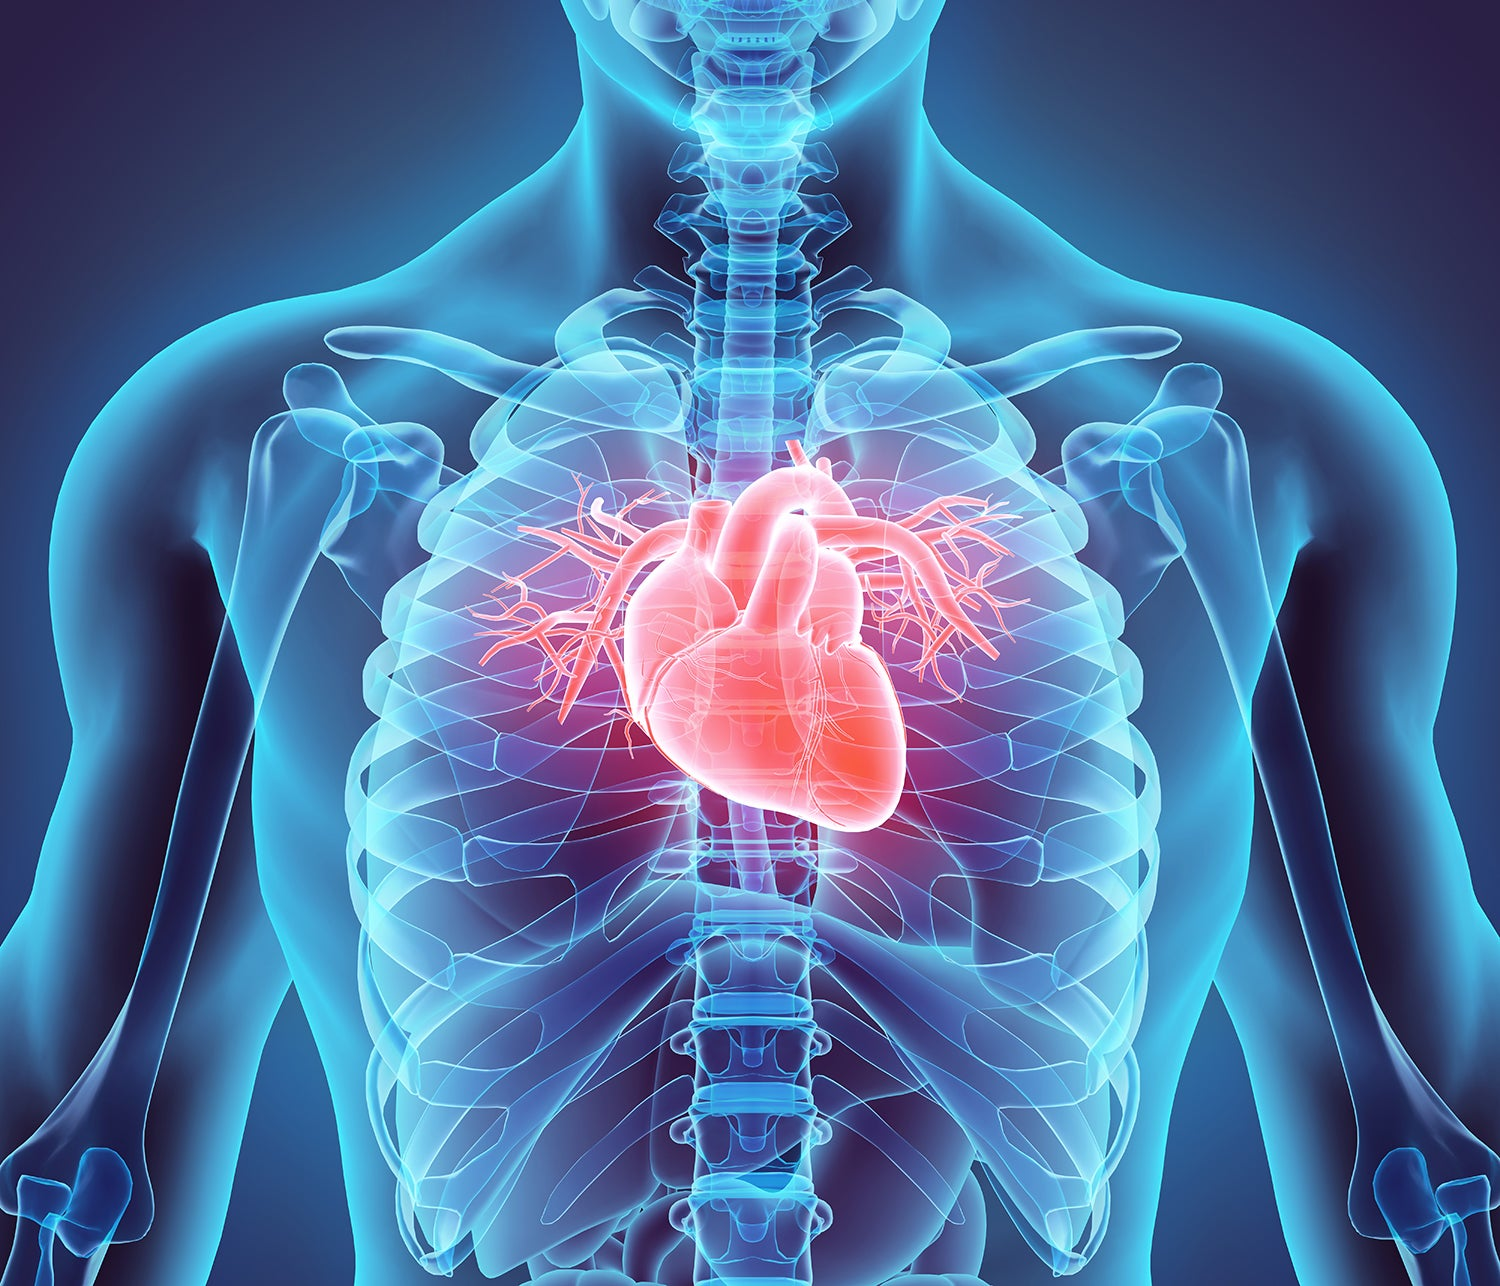


#Introduction:

Cardiovascular diseases kill approximately 17 million people globally every year, and they mainly exhibit as myocardial infarctions and heart failures. 

Heart failure (HF) occurs when the heart cannot pump enough blood to meet the needs of the body.

Available electronic medical records of patients quantify symptoms, body features, and clinical laboratory test values, which can be used to perform biostatistics analysis aimed at highlighting patterns and correlations otherwise undetectable by medical doctors. 

Machine learning, in particular, can predict patients’ survival from their data and can individuate the most important features among those included in their medical records.

Source 
https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5

Dataset 
http://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records

In this proposal, we analyze a dataset of 299 patients with heart failure collected in 2015. 

We apply several machine learning classifiers to both predict the patients’ survival, and rank the features corresponding to the most important risk factors. 

Since both feature ranking approaches clearly identify serum creatinine and ejection fraction as the two very relevant features, we then build the machine learning survival prediction models on these two factors at least.

### KDD stages:
The KDD (Knowledge Discovery in Databases) stages will occur according to the following figure

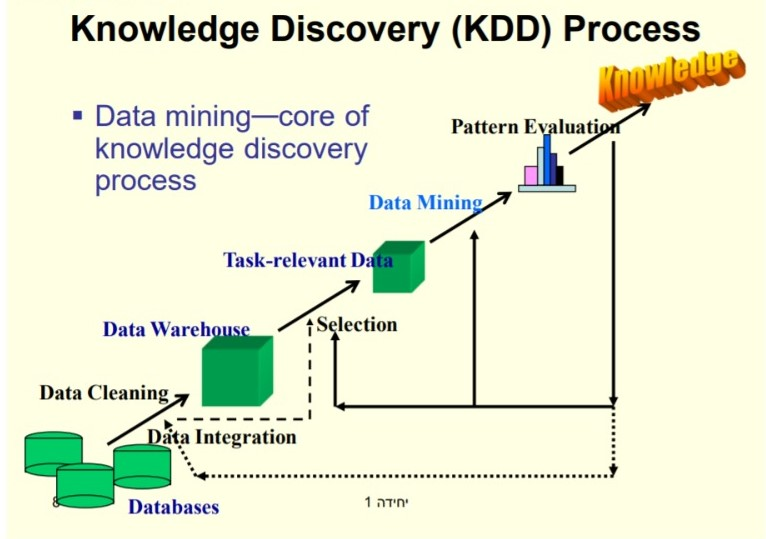


# Imports

Here we listed the main libraries used:


*   Numpy: Standard library for math operations on arrays
*   Pandas: Used to manipulate data inside dataframes and for basic computations
*   Sklearn: Used to apply different ML algorithms/models to the data
*   Matplotlib: Plot visualizations
*   Seaborn: Built on top of pyplot for nicer visualizations and easier plotting
*   Keras: Deep learning API written in Python, running on top of the machine learning platform TensorFlow allowing fast experimentation.
*   TPOT: AutoML library in python that optimizes ML pipelines using genetic programming.

*   SMOTE: Oversampling library that generates synthetic samples from the minority class.
It is used to obtain a synthetically class-balanced or nearly class-balanced training set, which is then used to train the classifier.

In [4]:
import warnings
def ignore_warn(*args,**kwargs):
  pass
warnings.warn = ignore_warn #ignore annoying warning from sklearn and seaborn 

In [5]:
# General
import pandas as pd
import numpy as np
import statsmodels.api as sm
from collections import Counter

# Debug
import pdb

# Plots 
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

# Scikit-Learn
import sklearn
from sklearn import tree
from sklearn import preprocessing
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split, GridSearchCV

# Imbalanced dataset
from imblearn.over_sampling import SMOTE

# Deep Learning
from keras import callbacks
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

# Auto ML
from tpot import TPOTClassifier

In [6]:
randomState = 42

In [7]:
df = pd.read_csv('heart_failure.csv')

# Dataset
This dataset contains the medical records of 299 patients who had heart failure, collected during their follow-up period, where each patient profile has 13 clinical features.

This is our legend.

Source
https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5/tables/1


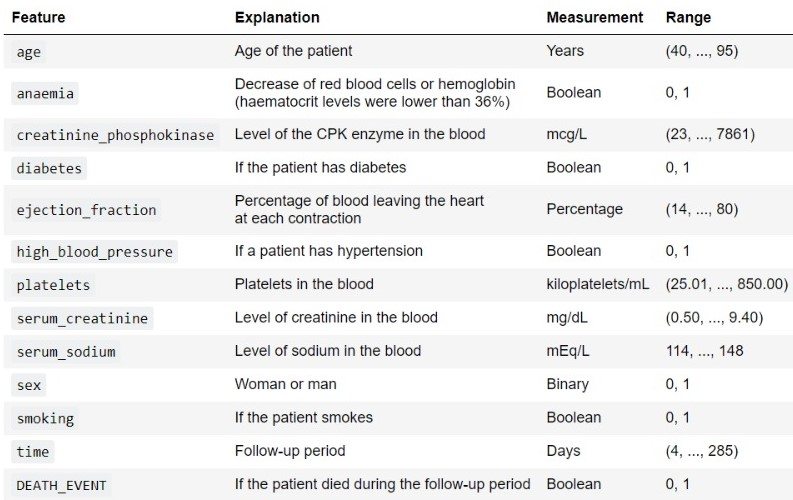

Quick impression of the data set:

In [8]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


Here we can see that none of are features has null values, and all of our features are numbers (ints & floats).

In [10]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


Here we can see that most features (except plateles and serum_sodium) have values according to the legend shown earlier.

We can see plateles is multiplied by 1000 so we'll adjust it according to our legend.

In [11]:
df.platelets = df.platelets/1000

In [12]:
df.platelets.describe()

count    299.000000
mean     263.358029
std       97.804237
min       25.100000
25%      212.500000
50%      262.000000
75%      303.500000
max      850.000000
Name: platelets, dtype: float64

We can see now according to the new min-max of plateles that our adjustment worked.

We can also see that serum_sodium has values below 114 (which is the minimum in our legend) so we'll drop the invalid values.


In [13]:
len(df[df.serum_sodium < 114])

1

Technically, there's only one sample with serum_sodium less than 114, so it makes sense to remove it.

Medically, severe hyponatremia (serum/plasma sodium <115 mmol/L), particularly of rapid onset, is associated with marked confusion, seizures and coma; without emergent treatment, severe hyponatremia can be fatal, and for that there is a great bias that the person has died because of that feather alone, which is not what we are predicting, we are predicting dying from heart failure.

In [14]:
df = df[df.serum_sodium >= 114]

In [15]:
df.serum_sodium.describe()

count    298.000000
mean     136.704698
std        4.201176
min      116.000000
25%      134.000000
50%      137.000000
75%      140.000000
max      148.000000
Name: serum_sodium, dtype: float64

We can see that now our min value in serum_sodium is 116 which is no less than 114 so we're aligned to our legend.

In [16]:
target = 'DEATH_EVENT'
boolean_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
numerical_features = list(set(df._get_numeric_data().columns)-set([target])-set(boolean_features))
categorical_features = list(set(df.columns)-set(numerical_features)-set([target]))
print(f'numerical features: {numerical_features}')
print(f'categorical features: {categorical_features}')

numerical features: ['serum_creatinine', 'ejection_fraction', 'platelets', 'age', 'creatinine_phosphokinase', 'serum_sodium', 'time']
categorical features: ['high_blood_pressure', 'anaemia', 'smoking', 'sex', 'diabetes']


# Outliers Detection

[Tukey method](https://en.wikipedia.org/wiki/Tukey%27s_range_test) is a single-step multiple comparison procedure and statistical test. 

It can be used to find means that are significantly different from each other.

It's a statistical tool used to determine if the relationship between two sets of data is statistically significant – that is, whether there's a strong chance that an observed numerical change in one value is causally related to an observed change in another value. 

In other words, the Tukey method is a way to test an experimental hypothesis.

In [17]:
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers  


rows_with_more_than_1_outlier = detect_outliers(df, 1 ,numerical_features)

Since outliers can have a dramatic effect on the prediction (espacially for regression problems), we chose to manage them.

Tukey method detects ouliers by defining an interquartile range comprised between the 1st and the 3rd quartile of the distribution values (IQR). 

An outlier is a row that have a feature value outside (IQR +- an outlier step).

In [18]:
df.loc[rows_with_more_than_1_outlier]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
4,65.0,1,160,1,20,0,327.00000,2.7,116,0,0,8,1
38,60.0,0,2656,1,30,0,305.00000,2.3,137,1,0,30,0
52,60.0,0,3964,1,62,0,263.35803,6.8,146,0,0,43,1
117,85.0,1,102,0,60,0,507.00000,3.2,138,0,0,94,0
167,59.0,0,66,1,20,0,70.00000,2.4,134,1,0,135,1
217,54.0,1,427,0,70,1,151.00000,9.0,137,0,0,196,1
281,70.0,0,582,0,40,0,51.00000,2.7,136,1,1,250,0
200,63.0,1,1767,0,45,0,73.00000,0.7,137,1,0,186,0
296,45.0,0,2060,1,60,0,742.00000,0.8,138,0,0,278,0


We only have 10 observations with more than 1 outlier in them - so we'll delete them

In [19]:
df_outliers = df.copy()
df = df.drop(rows_with_more_than_1_outlier, axis=0).reset_index(drop=True)

We can see that now we have only 289 rows instead of 299 rows (which makes sense because we had only 10 rows with more than 1 outlier)
we will keep a copy of the original dataframe with the outliers to check if the models perform better on it or not.

# Missing Values

In [20]:
df.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

Here we can see again that no feature has missing values like we saw earlier.

# Correlation matrix

correlation matrix is simply a table which displays the linear relationships between each pair of features (including the target).


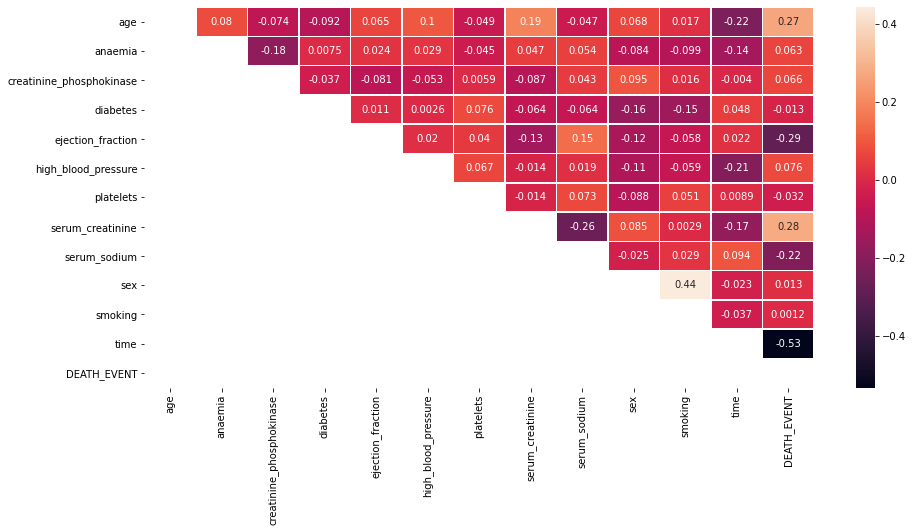

In [21]:
corr = df.corr()
matrix = np.tril(corr)
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(corr, annot=True, mask=matrix, linewidths=.5);

We can see that there's a positive linear relationship between sex & smoking (0.44).

We can also see a positive linear relationship between serum_creatinine, serum_sodium to DEATH_EVENT.

Also, we have a negative linear relationship between ejection_fraction to DEATH_EVENT.


# Feature distributions

In [22]:
# skewness along the index axis
df.skew(axis = 0, skipna = True)

age                         0.420392
anaemia                     0.273811
creatinine_phosphokinase    4.785768
diabetes                    0.360442
ejection_fraction           0.548999
high_blood_pressure         0.587010
platelets                   1.396723
serum_creatinine            4.640507
serum_sodium               -0.379035
sex                        -0.650762
smoking                     0.749900
time                        0.133241
DEATH_EVENT                 0.784017
dtype: float64

Skewness is the degree of distortion from a normal distribution.

It measures the lack of symmetry in the data distribution.

We can see the skewness of every feature in such a way that positive numbers indicate we have a right tale, and negative numbers indicate we have a left tale.

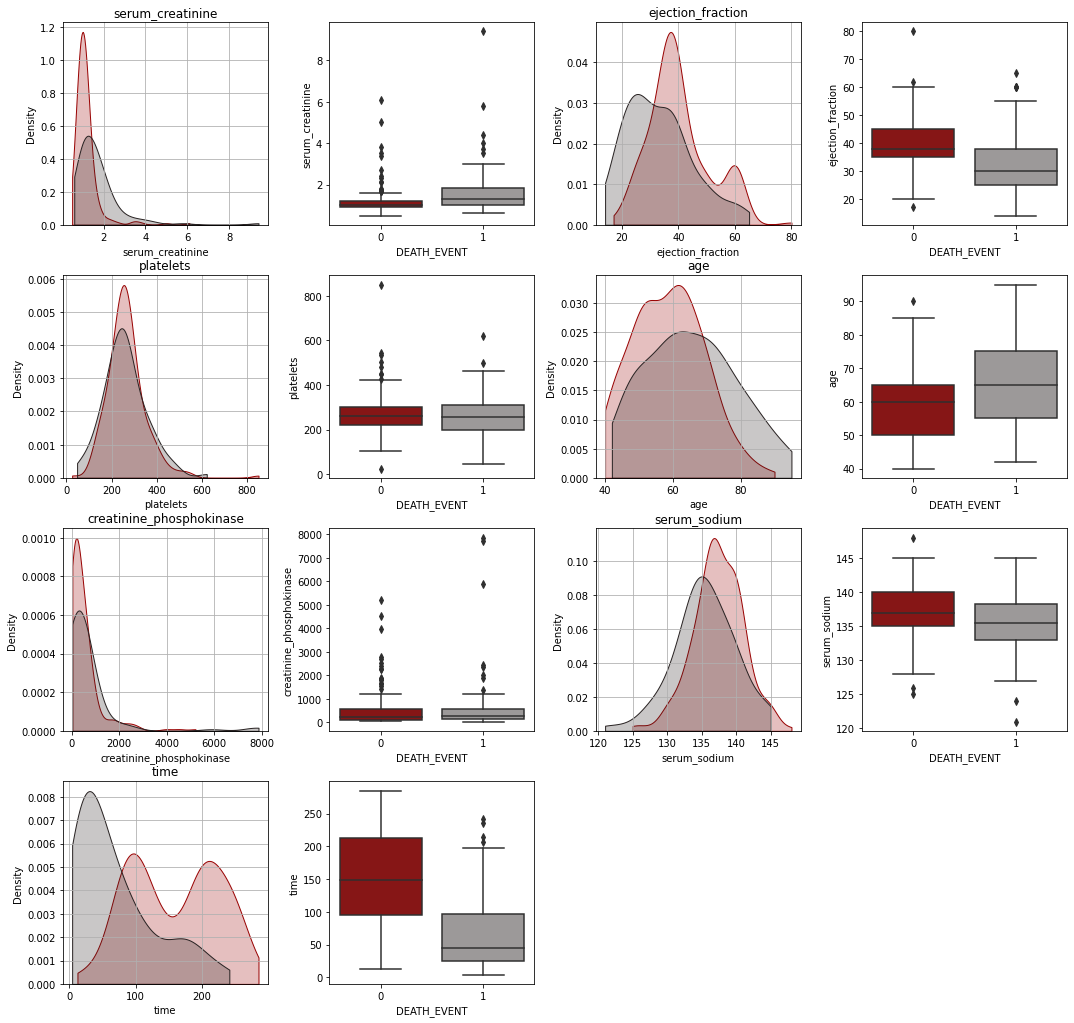

In [23]:
plt.figure(figsize=(18, 27))

for i, col in enumerate(numerical_features):
    plt.subplot(6, 4, i*2+1)
    plt.subplots_adjust(hspace =.25, wspace=.3)
    plt.grid(True)
    plt.title(col)
    sns.kdeplot(df.loc[df[target]==0, col], label="alive", color = "#990303", shade=True, kernel='gau', cut=0)
    sns.kdeplot(df.loc[df[target]==1, col], label="dead",  color = "#292323", shade=True, kernel='gau', cut=0)
    plt.subplot(6, 4, i*2+2)
    sns.boxplot(y = col, data = df, x=target, palette = ["#990303", "#9C9999"])   

Here we can see graphically the skewness of every feature by a boxplot and by a distribution for each label.

"A box plot (or box-and-whisker plot) shows the distribution of quantitative
data in a way that facilitates comparisons between variables or across
levels of a categorical variable. The box shows the quartiles of the
dataset while the whiskers extend to show the rest of the distribution,
except for points that are determined to be "outliers" using a method
that is a function of the inter-quartile range." - from seaborn documentation

A report of the categorical features:

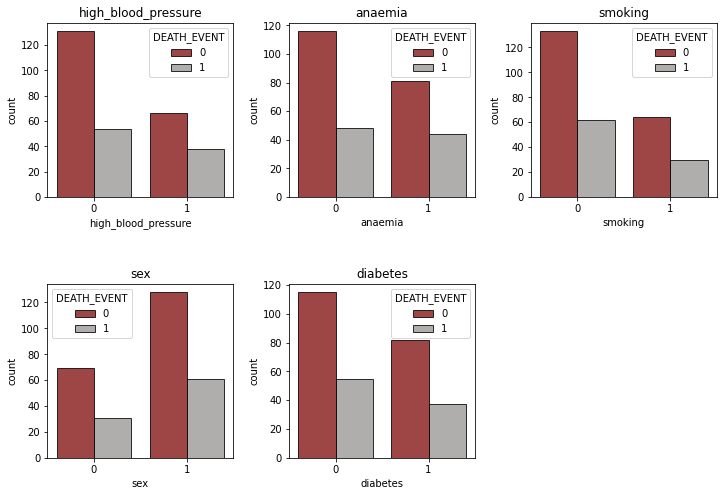

In [24]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(categorical_features):
    plt.subplot(2, 3, i+1)
    plt.title(col)
    plt.subplots_adjust(hspace =.5, wspace=.3)
    sns.countplot(data=df, x=col, hue=target, palette = ["#990303", "#9C9999"], alpha=0.8, edgecolor="k", linewidth=1)

We can see above the boolean features that might affect the DEATH_EVENT.

For example:
 
sex:
The percentage of dead men (out of all men) is ~33%, and the percentage of dead women (out of all women) is also ~33%.

The conclusion is that sex does NOT affect DEATH_EVENT.

high_blood_pressure: 
The percentage of dead high blood pressure people (out of all high blood pressure people) is ~40%, and the percentage of dead normal blood pressure people (out of all normal blood pressure people) is ~30%.

The conclusion is that high_blood_pressure DOES affect DEATH_EVENT.


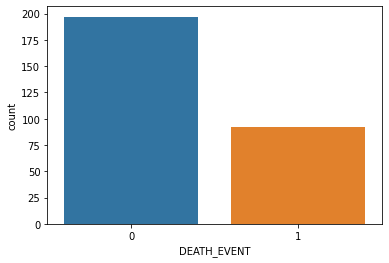

In [25]:
sns.countplot(df[target])

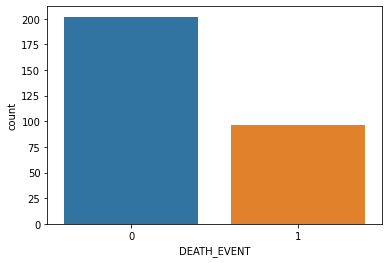

In [26]:
sns.countplot(df_outliers[target])

We can obviously see that out dataset is imbalaned so we need to balance the data - we'll do it using SMOTE which is the most popular way of balancing an imbalanced dataset.



In [27]:
X = df.drop(columns=target)
y = df[target]

In [28]:
X_outliers = df_outliers.drop(columns=target)
y_outliers = df_outliers[target]

# Reduce skewness distribution**


**What is Data Skewness**? Data Skewness is asymmetry in a statistical distribution, in which the curve appears distorted or skewed either to the left or to the right. Skewness can be quantified to define the extent to which a distribution differs from a normal distribution.


**Reducing skewness:** A data transformation may be used to reduce skewness. A distribution that is symmetric or nearly so is often easier to handle and interpret than a skewed distribution. More specifically, a normal or Gaussian distribution is often regarded as ideal as it is assumed by many statistical methods.

**Forms of skewness**:

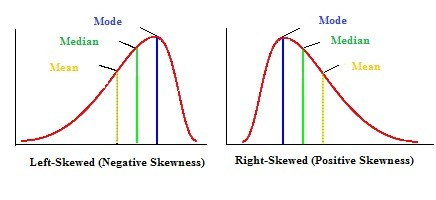

In [29]:
def show_feature_skewness(X,feature_str):
  g = sns.distplot(X[feature_str], 
                  color="b", 
                  label="Skewness : %.2f"%(X[feature_str].skew()))
  g = g.legend(loc="best")

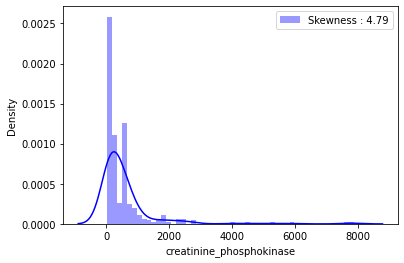

In [30]:
show_feature_skewness(X,"creatinine_phosphokinase")

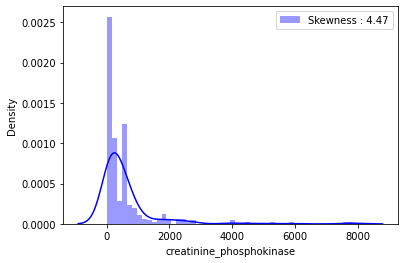

In [31]:
show_feature_skewness(X_outliers,"creatinine_phosphokinase")

**Reducing Right Skewness**
Right skewness can be reduced applying following transformation

Logarithms: The logarithm, x to log base 10 of x, or x to log base e of x (ln x), or x to log base 2 of x, is a strong transformation with a major effect on distribution shape. It is commonly used for reducing right skewness and is often appropriate for measured variables. It can not be applied to zero or negative values.

Apply log to reduce skewness distribution

In [32]:
def reduce_skenwness_distribution(dataframe, col):
  dataframe[col] = dataframe[col].map(lambda i: np.log(i) if i > 0 else 0)

In [33]:
# Apply log to reduce skewness distribution
reduce_skenwness_distribution(X, 'creatinine_phosphokinase')

In [34]:
# Apply log to reduce skewness distribution
reduce_skenwness_distribution(X_outliers, 'creatinine_phosphokinase')

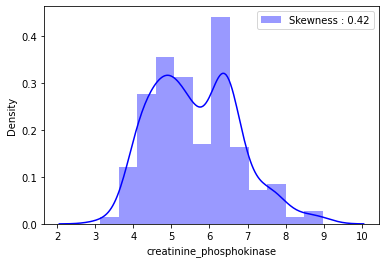

In [35]:
show_feature_skewness(X,"creatinine_phosphokinase")

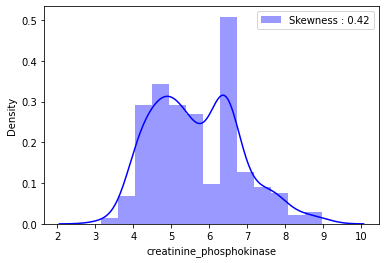

In [36]:
show_feature_skewness(X_outliers, "creatinine_phosphokinase")

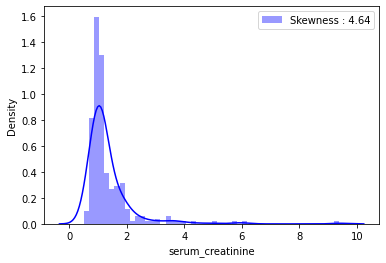

In [37]:
show_feature_skewness(X, "serum_creatinine")

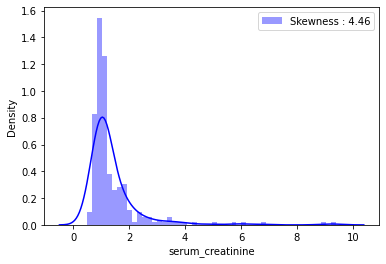

In [38]:
show_feature_skewness(X_outliers,"serum_creatinine")

In [39]:
# Apply log to reduce skewness distribution
reduce_skenwness_distribution(X, 'serum_creatinine')

In [40]:
# Apply log to reduce skewness distribution
reduce_skenwness_distribution(X_outliers, 'serum_creatinine')

Let's take a look on the balanced creatine_phosphokinase and serum_creatinine features:

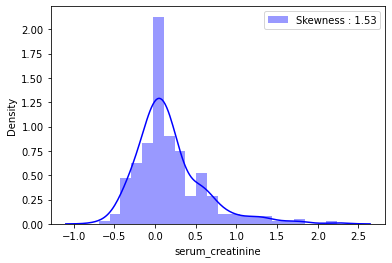

In [41]:
show_feature_skewness(X, "serum_creatinine")

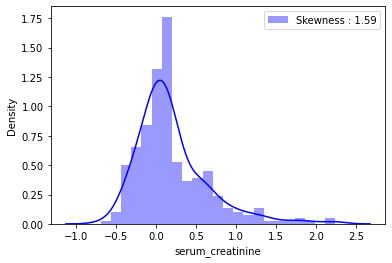

In [42]:
show_feature_skewness(X_outliers,"serum_creatinine")

**Normalization**

We want to normalize the data because it will give us insights about which features are the most important for the regression, because the bigger the coefficient (weight) the more important the feature.

Without normalization, we would assume by mistake a big importance to a not important feature and a small importance to an important feature.

Also, it doesn't harm the accuracy of the decision tree.

We'll use Standard_scaler which standardizes features by removing the mean and scaling to unit variance

The standard score of a sample x is calculated as:

z = (x - u) / s

where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.


In [43]:
def standard_scaler(X):
  #Set up a standard scaler for the features
  col_names = list(X.columns)
  s_scaler = preprocessing.StandardScaler()
  X_df= s_scaler.fit_transform(X)
  X_df = pd.DataFrame(X_df, columns=col_names)
  return X_df  

In [44]:
X = standard_scaler(X)

In [45]:
X_outliers = standard_scaler(X_outliers)

Executing train_test_split in the right timing!

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randomState, stratify=y)

In [47]:
X_train_outliers, X_test_outliers, y_train_outliers, y_test_outliers = train_test_split(X_outliers, y_outliers, test_size=0.2, random_state=randomState, stratify=y_outliers)

Because X, y (X_outliers, y_outliers) were split stratified, then we know that y_train & y_test has the same distribution of y-values as y itself.

# SMOTE

Imbalanced classification involves developing predictive models on classification datasets that have a severe class imbalance.

The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important and in our case is the number of deads from heart failure.

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.

In this reserach proposal, we will use SMOTE for oversampling imbalanced classification datasets.

explanation has been taken from - https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

**SMOTE** works by utilizing a k-nearest neighbor algorithm to create synthetic data. 

SMOTE first start by choosing random data from the minority class, then k-nearest neighbors from the data are set. 

Synthetic data would then made between the random data and the randomly selected k-nearest neighbor.

In [48]:
# With SMOTE - Check if outliers improve score

In [49]:
def oversample_features_target(X, y):
  return SMOTE(random_state=randomState, n_jobs=-1, k_neighbors=5).fit_resample(X, y)

only 4 types of training datasets & test sets from now on:

1. no outliers & no smote ----> tested with X_test/y_test

2. no outliers & smote  ------> tested with X_test/y_test

3. outliers & no smote ------> tested with X_test_outliers/y_test_outliers

4. outlers & smote -------> tested with X_test_outliers/y_test_outliers




In [50]:
X_train_nooutliers_nosmote , y_train_nooutliers_nosmote = X_train, y_train
X_train_nooutliers_smote , y_train_nooutliers_smote = oversample_features_target(X_train, y_train)
X_train_outliers_nosmote , y_train_outliers_nosmote = X_train_outliers , y_train_outliers
X_train_outliers_smote, y_train_outliers_smote = oversample_features_target(X_train_outliers, y_train_outliers)

In [51]:
# important lines
X_train_nooutliers_smote = pd.DataFrame(np.matrix(X_train_nooutliers_smote),columns=X.columns)
X_train_outliers_smote = pd.DataFrame(np.matrix(X_train_outliers_smote),columns=X.columns)

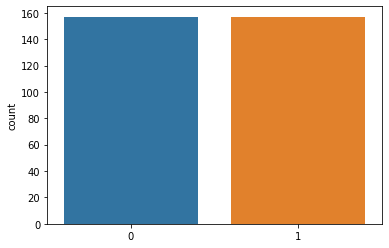

In [52]:
sns.countplot(y_train_nooutliers_smote)

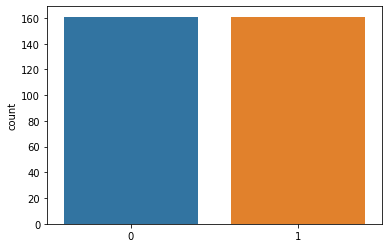

In [53]:
sns.countplot(y_train_outliers_smote)

Now we can see the data is balanced so SMOTE worked!

**Feature importance of tree based classifiers**

In order to see the most informative features for the prediction of patients survival, we displayed the feature importance for the upcoming trees.

In [54]:
DTC_nooutliers_smote = DecisionTreeClassifier(criterion='gini', random_state=randomState).fit(X_train_nooutliers_smote, y_train_nooutliers_smote)

In [55]:
DTC_nooutliers_nosmote = DecisionTreeClassifier(criterion='gini', random_state=randomState).fit(X_train_nooutliers_nosmote, y_train_nooutliers_nosmote)

In [56]:
DTC_outliers_smote = DecisionTreeClassifier(criterion='gini',random_state=randomState).fit(X_train_outliers_smote, y_train_outliers_smote)

In [57]:
DTC_outliers_nosmote = DecisionTreeClassifier(criterion='gini',random_state=randomState).fit(X_train_outliers_nosmote, y_train_outliers_nosmote)

In [58]:
def feature_importances_in_DTC(X_cols,DTC):
  nrows = ncols = 1 
  fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15, 15), squeeze=False)
  names_classifiers = [("Descision Tree - Gini Based.", DTC)] #<---you can add to that list more tree models
  nclassifier = 0
  best_3_features_per_model = []
  for row in range(nrows):
    for col in range(ncols):
      name = names_classifiers[nclassifier][0]
      classifier = names_classifiers[nclassifier][1]
      indices = np.argsort(classifier.feature_importances_)[::-1][:13]
      g = sns.barplot(y = X_cols[indices][:13],
                      x = classifier.feature_importances_[indices][:13], 
                      orient ='h',
                      ax=axes[row][col])
      best_3_features_per_model.append(X_cols[indices][:3])
      g.set_xlabel("Relative importance", fontsize=12)
      g.set_ylabel("Features", fontsize=12)
      g.tick_params(labelsize=9)
      g.set_title(name + " feature importance")
      nclassifier += 1
  return best_3_features_per_model      

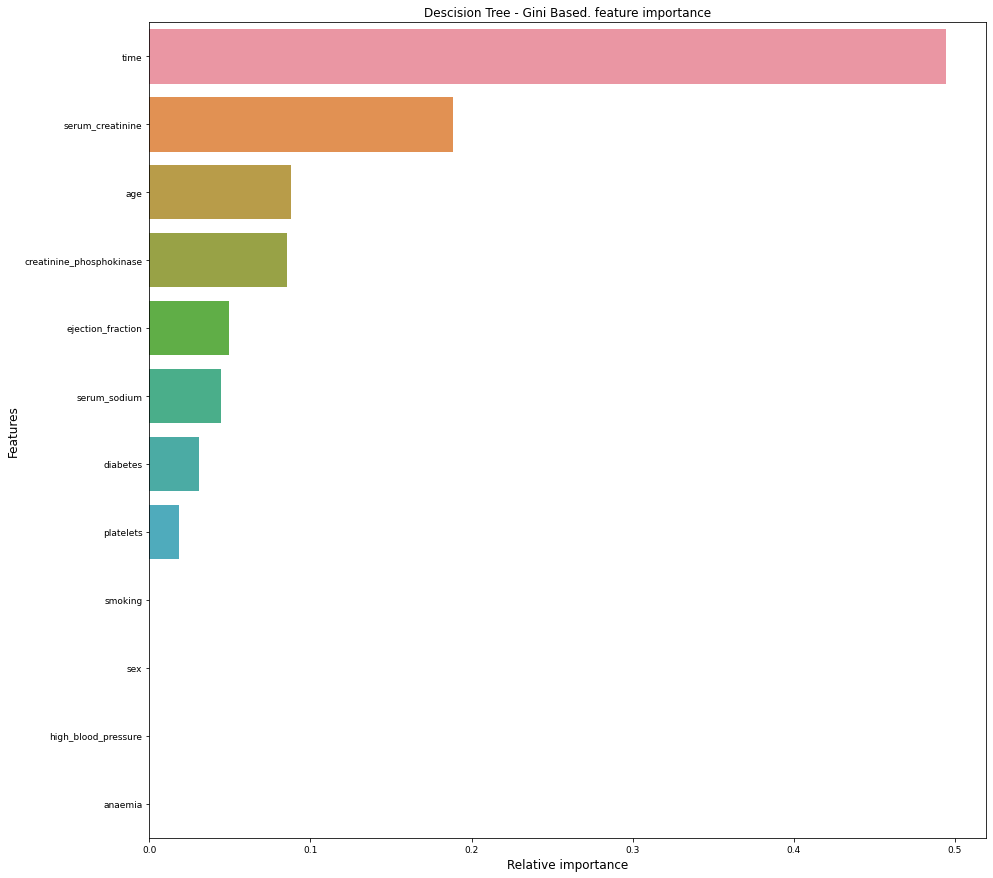

In [59]:
important_features_of_DTC_nooutliers_smote = feature_importances_in_DTC(X.columns,DTC_nooutliers_smote)[0]

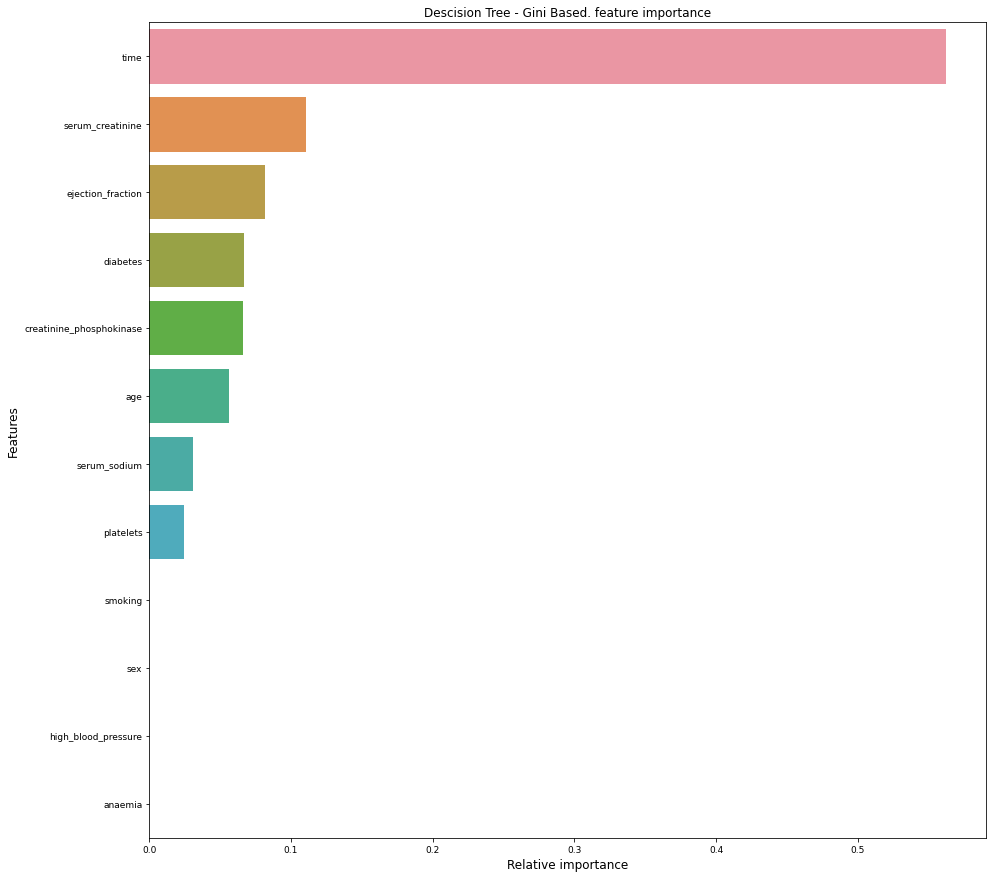

In [60]:
important_features_of_DTC_nooutliers_nosmote = feature_importances_in_DTC(X.columns,DTC_nooutliers_nosmote)[0]

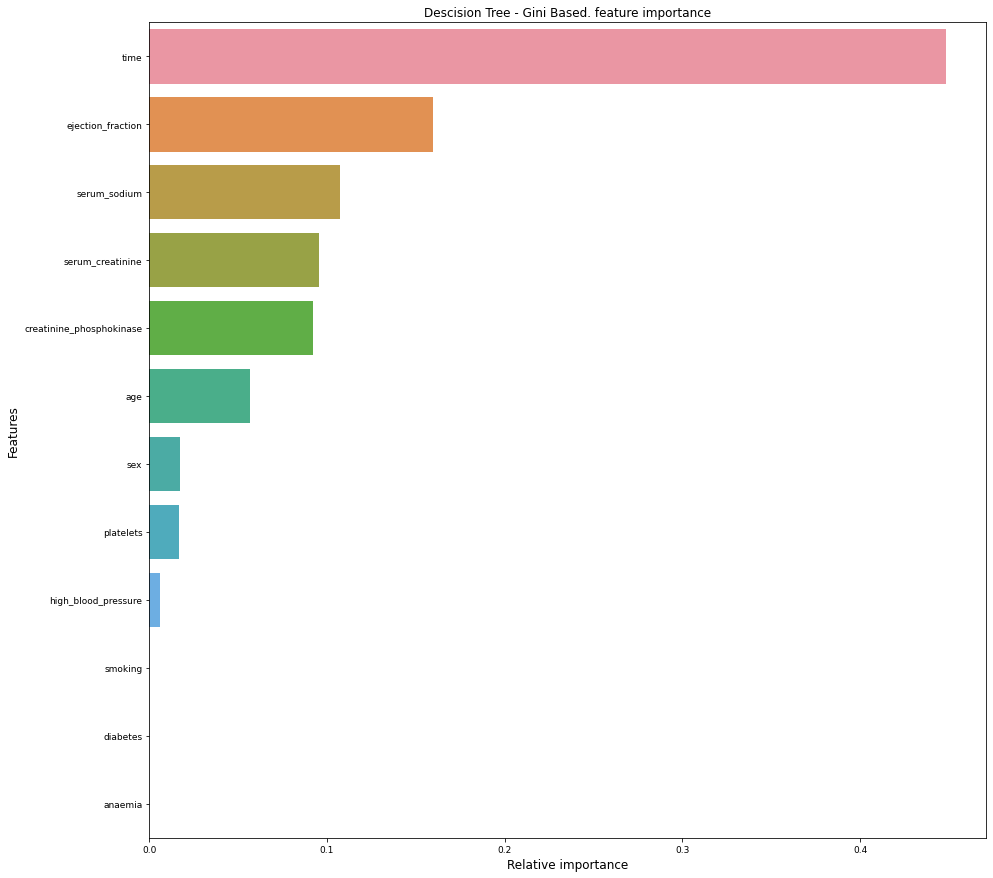

In [61]:
important_features_of_DTC_outliers_smote = feature_importances_in_DTC(X_outliers.columns, DTC_outliers_smote)[0]

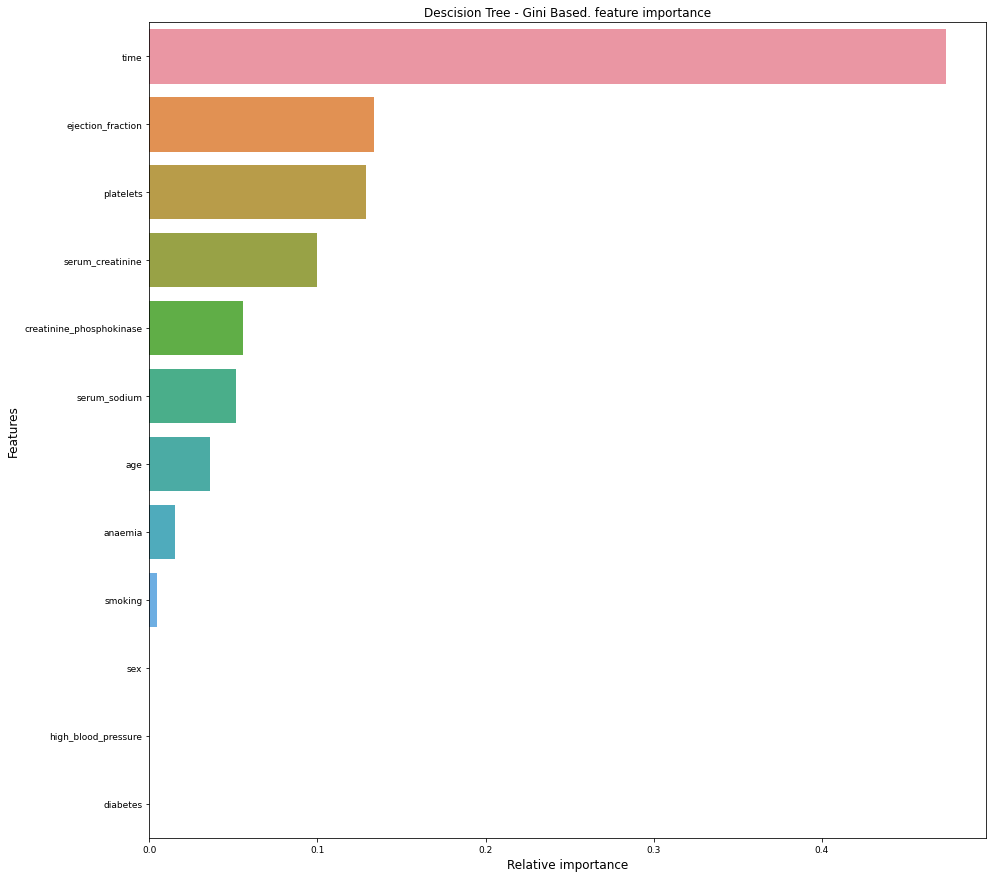

In [62]:
important_features_of_DTC_outliers_nosmote = feature_importances_in_DTC(X_outliers.columns, DTC_outliers_nosmote)[0]

Conclusions from the importance level of the features:



* **Time:** the time that has pass from the heart failure of a patient is very important for his death prediction.
* **serum creatinine:** doctors belives thats increased creatinine levels during hospitalization are a marker of poor cardiac output, leading to diminished renal blood flow and reduced ability to tolerate inpatient heart failure treatment. their belife is confirmed by the above graph .
* **ejection fraction:** each 10% reduction in ejection fraction is independently associated with a significant increased risk of death due to any cause, cardiovascular death, sudden death, death due to **heart failure**, 
those facts are confirmed by the above graph .
* **other** features aren't very important

There is not much noise in these features, as we showed in the previous analysis above, so there is nothing to worry about performance degradation


**We will run the decision tree algorithm later again but will filter out unimportant attributes.**

###Base Models that has been chosen for the specific problem:

We chose decision tree and logistic regression, because it is possible that the data maintains a linear relationship and therefore logistic regression can find it, or it is possible that the data does not necessarily have a linear relationship and therefore a decision tree can map it.

**Logistic regression** is a statistical model that describes a possible relationship between a qualitative / categorical variable, known as the "explained variable", and other variables called "explanatory variables". The explanatory variables can be qualitative or quantitative. The model makes it possible to estimate the extent of the effect of a change in its value on each of the variables that explain the value of the explained variable. In other words, the model makes it possible to estimate correlations between the explanatory variables and the explained variable. The model alone is not sufficient to establish a causal relationship between the explanatory variables and the explained variable. The logistic regression model is a particular case of the integrated linear model. ***That is, the premise for using this algorithm is that the data maintains a linear relationship.***


**Decision tree** is a prediction model that provides a mapping between observations and the appropriate values ​​for them,decision tree is a flow chart spring, in which each internal node (not a leaf) indicates a test on a feature, each branch represents a test result, and each leaf node holds a grade label. The highest node in a tree is the root
A decision tree can be run so that the split is according to the Entropy Index (IG) or the Gini Index.
it is not necessarily linear like logistic regression, we chose to use the Gini index because the entropy range ranges from 0 to 1 and the range of contamination in Gini ranges from 0 to 0.5. From this we can conclude that the impurity in Ginny is better compared to entropy for choosing the best features for splitting a junction




# Hyperparameter tunning for best models



The process of hyperparameter tunning is about finding the best set of parameters for our training (learning) process that maximize the score (accuracy, precision, recall, F1, etc) of our model so that it will generalize unseed data (reality) as much as possible.

Some features have a linear relationship with the target and some don't.

We chose Logistic Regression which is based on linear relationships & Decision Tree which is not based on linear relationships to see what will perform better (in terms of score).

**Desicion tree model:**
  let's find first the max_depth for the Decision tree

In [63]:
def DTCs_grid_search(X, y, important_features_DTC):
  criterion = ['gini', 'entropy'] 
  max_depth = [2, 4, 6, 8, 10, 12]

  dec_tree = DecisionTreeClassifier()

  pipe = Pipeline(steps=[('dec_tree', dec_tree)])
  parameters = dict(dec_tree__criterion=criterion, dec_tree__max_depth=max_depth)
  clf_GS = GridSearchCV(pipe, parameters)
  clf_GS.fit(X[important_features_DTC], y)
  return clf_GS

In [64]:
clf_GS_nooutliers_smote = DTCs_grid_search(X_train_nooutliers_smote ,y_train_nooutliers_smote, important_features_of_DTC_nooutliers_smote)

In [65]:
clf_GS_nooutliers_nosmote = DTCs_grid_search(X_train_nooutliers_nosmote ,y_train_nooutliers_nosmote, important_features_of_DTC_nooutliers_nosmote)

In [66]:
clf_GS_outliers_smote = DTCs_grid_search(X_train_outliers_smote, y_train_outliers_smote, important_features_of_DTC_outliers_smote)

In [67]:
clf_GS_outliers_nosmote = DTCs_grid_search(X_train_outliers_nosmote, y_train_outliers_nosmote, important_features_of_DTC_outliers_nosmote)

In [68]:
def DTC_print_gridsearch_result(clf_GS):
  print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion'])
  print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])
  print(clf_GS.best_estimator_.get_params()['dec_tree'])

In [69]:
DTC_print_gridsearch_result(clf_GS_nooutliers_smote)

Best Criterion: gini
Best max_depth: 2
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [70]:
DTC_print_gridsearch_result(clf_GS_nooutliers_nosmote)

Best Criterion: gini
Best max_depth: 10
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [71]:
DTC_print_gridsearch_result(clf_GS_outliers_smote)

Best Criterion: entropy
Best max_depth: 12
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=12, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [72]:
DTC_print_gridsearch_result(clf_GS_outliers_nosmote)

Best Criterion: entropy
Best max_depth: 4
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


We found that  max_depth and best criterion

In [73]:
def get_DTC_params_cols(model_GS, X_train, y_train, X_test, important_features):
  max_depth = model_GS.best_estimator_.get_params()['dec_tree__max_depth']
  best_criterion = model_GS.best_estimator_.get_params()['dec_tree__criterion']
  DTC = DecisionTreeClassifier(criterion=best_criterion, max_depth=max_depth)
  DTC = DTC.fit(X_train[important_features], y_train)
  y_pred = DTC.predict(X_test[important_features])
  return DTC, best_criterion, max_depth, y_pred

In [74]:
best_DTC_nooutliers_smote, best_criterion_nooutliers_smote, max_depth_nooutliers_smote, y_pred_nooutliers_smote = get_DTC_params_cols(clf_GS_nooutliers_smote, X_train_nooutliers_smote, y_train_nooutliers_smote, X_test, important_features_of_DTC_nooutliers_smote)

In [75]:
best_DTC_nooutliers_nosmote, best_criterion_nooutliers_nosmote, max_depth_nooutliers_nosmote, y_pred_nooutliers_nosmote = get_DTC_params_cols(clf_GS_nooutliers_nosmote, X_train_nooutliers_nosmote, y_train_nooutliers_nosmote, X_test, important_features_of_DTC_nooutliers_nosmote)

In [76]:
best_DTC_outliers_smote, best_criterion_outliers_smote, max_depth_outliers_smote, y_pred_outliers_smote = get_DTC_params_cols(clf_GS_outliers_smote, X_train_outliers_smote, y_train_outliers_smote, X_test_outliers,important_features_of_DTC_outliers_smote)

In [77]:
best_DTC_outliers_nosmote, best_criterion_outliers_nosmote, max_depth_outliers_nosmote, y_pred_outliers_nosmote = get_DTC_params_cols(clf_GS_outliers_nosmote, X_train_outliers_nosmote, y_train_outliers_nosmote, X_test_outliers,important_features_of_DTC_outliers_nosmote)

Let's see the new Decision tree.

In [78]:
def present_DTC(DTC, important_features_DTC, y):
  fig = plt.figure(figsize=(25, 20))
  sklearn.tree.plot_tree(DTC,
                         feature_names=important_features_DTC,
                         class_names=target,
                         filled=True)

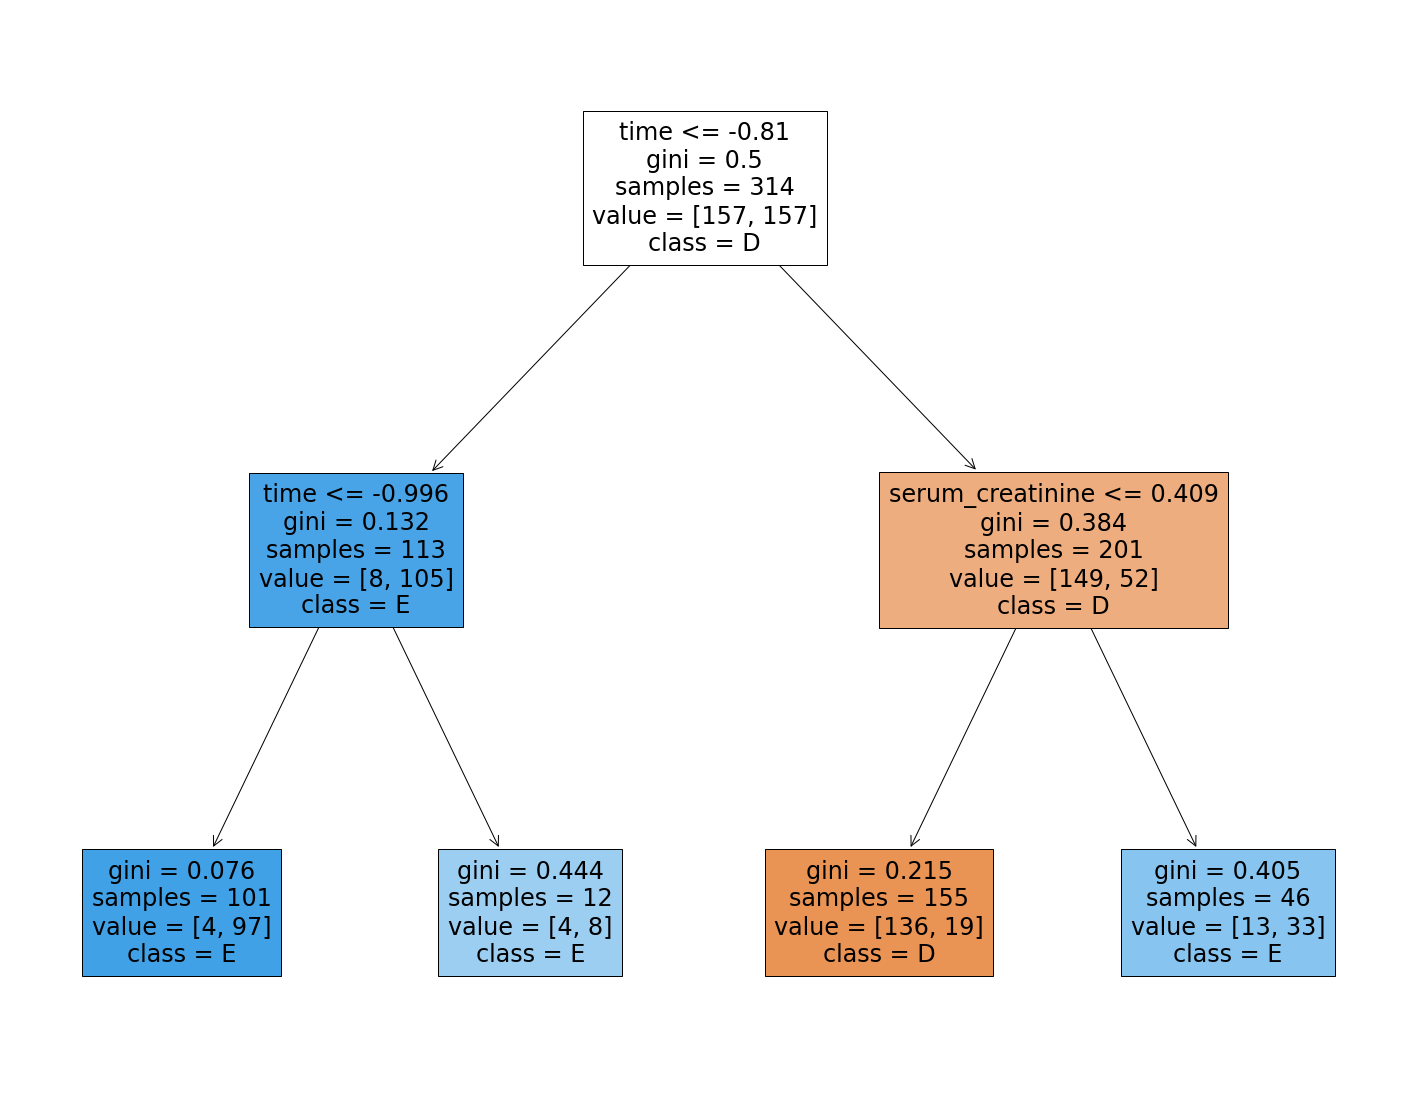

In [79]:
present_DTC(best_DTC_nooutliers_smote, important_features_of_DTC_nooutliers_smote, y)

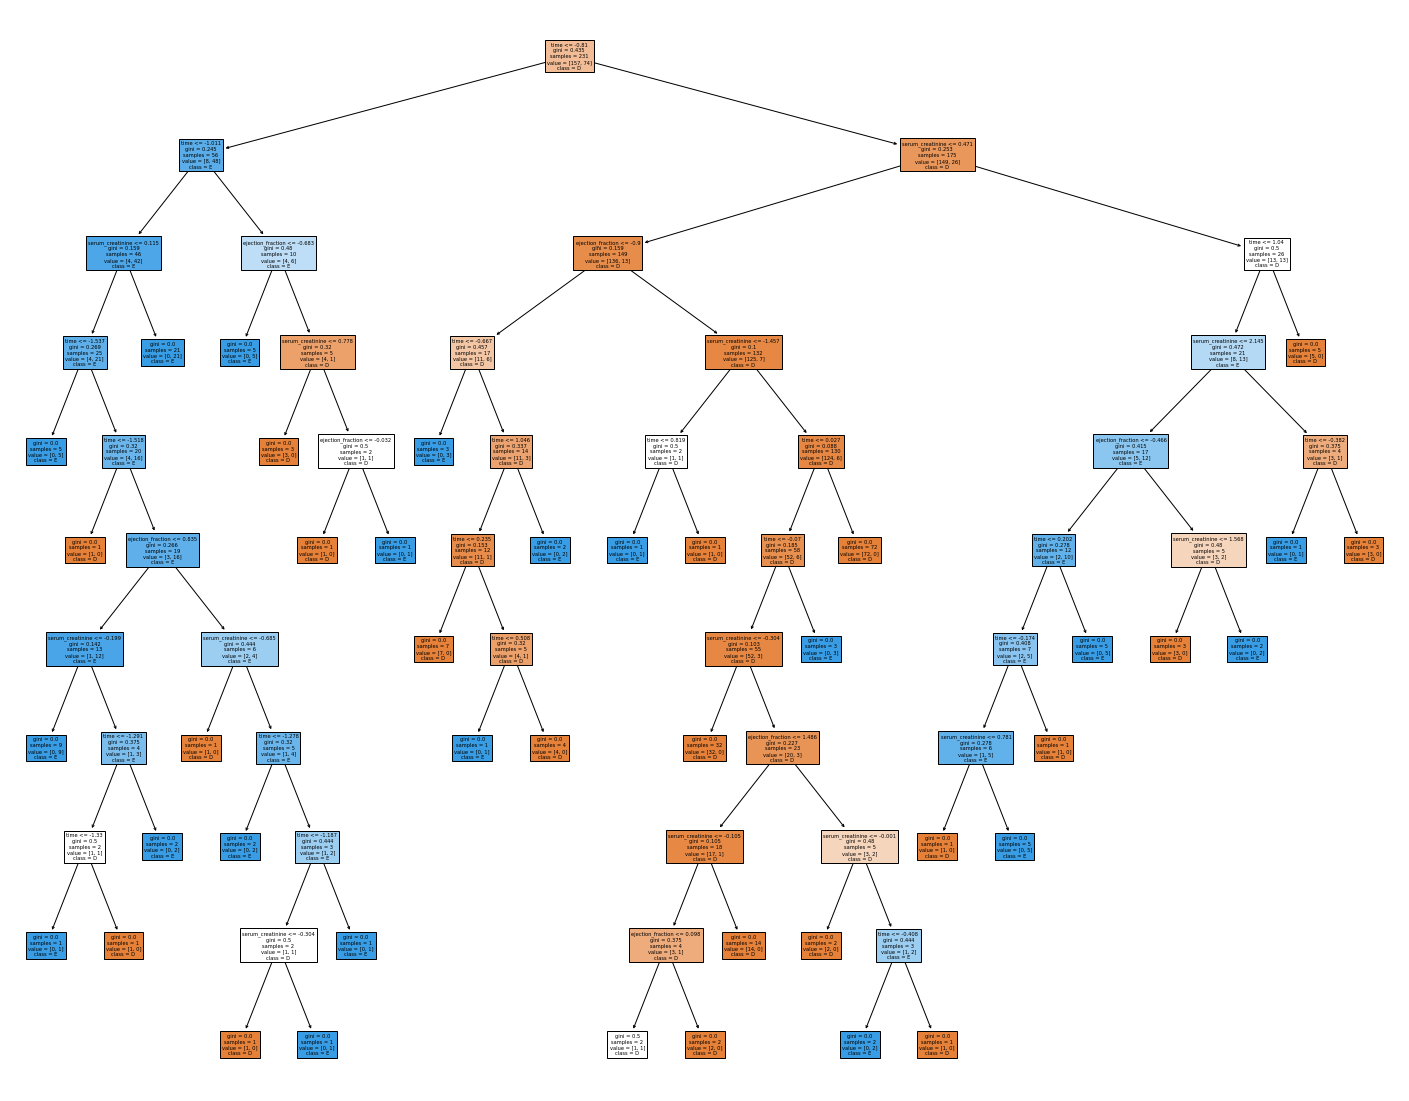

In [80]:
present_DTC(best_DTC_nooutliers_nosmote, important_features_of_DTC_nooutliers_nosmote, y)

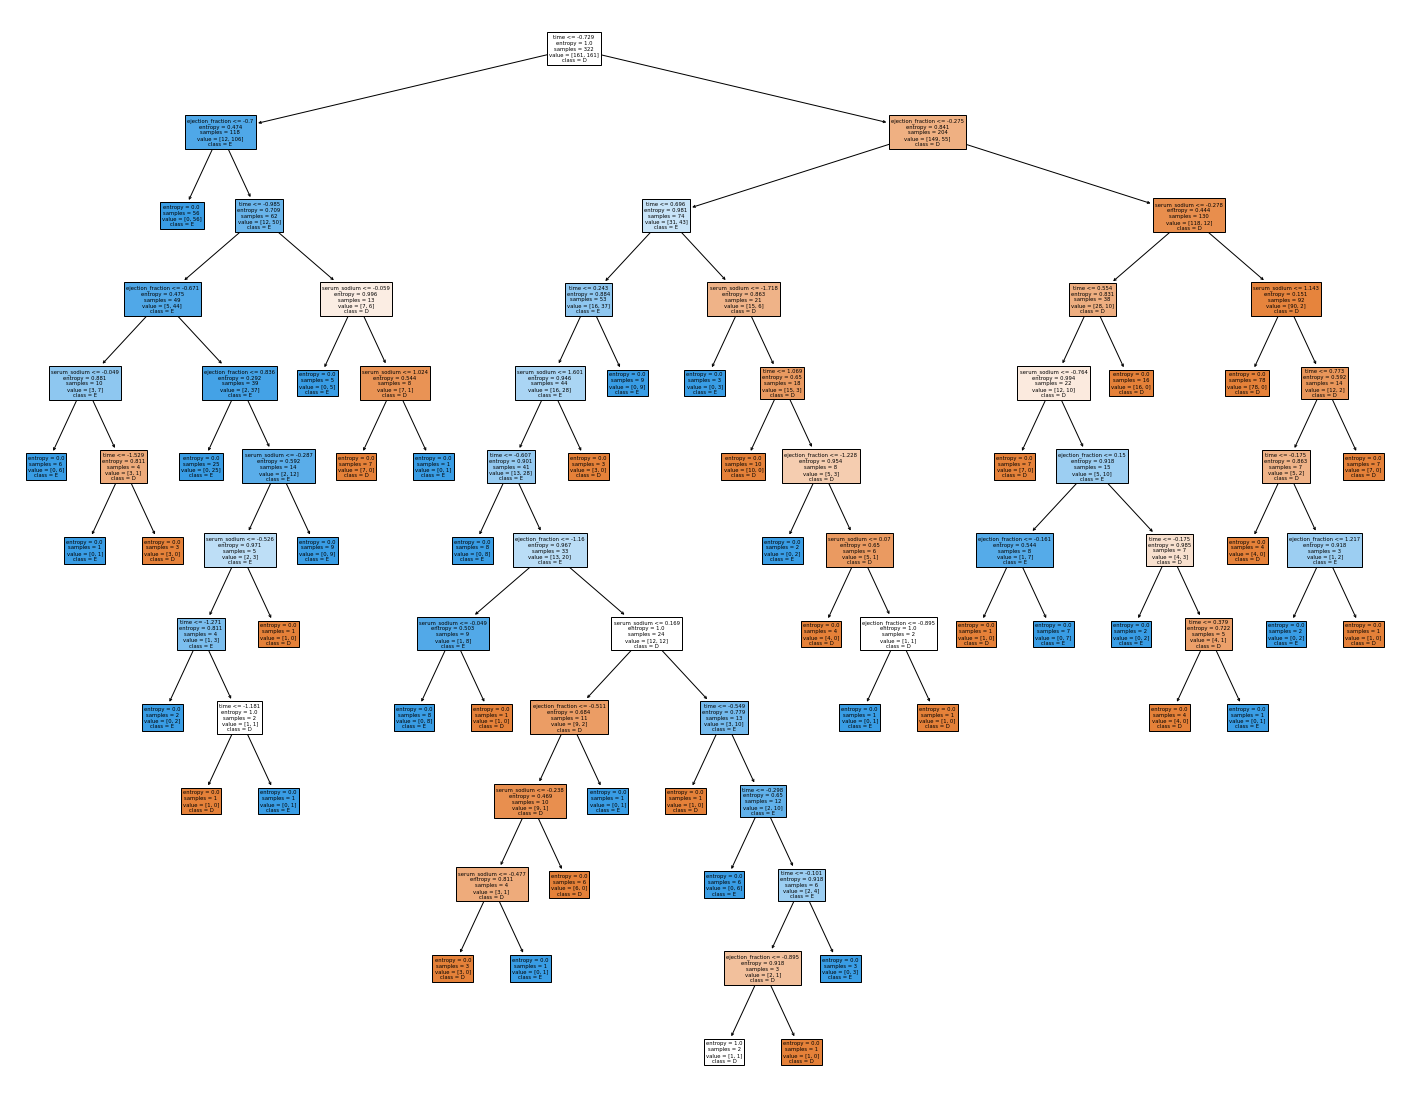

In [81]:
present_DTC(best_DTC_outliers_smote, important_features_of_DTC_outliers_smote, y_outliers)

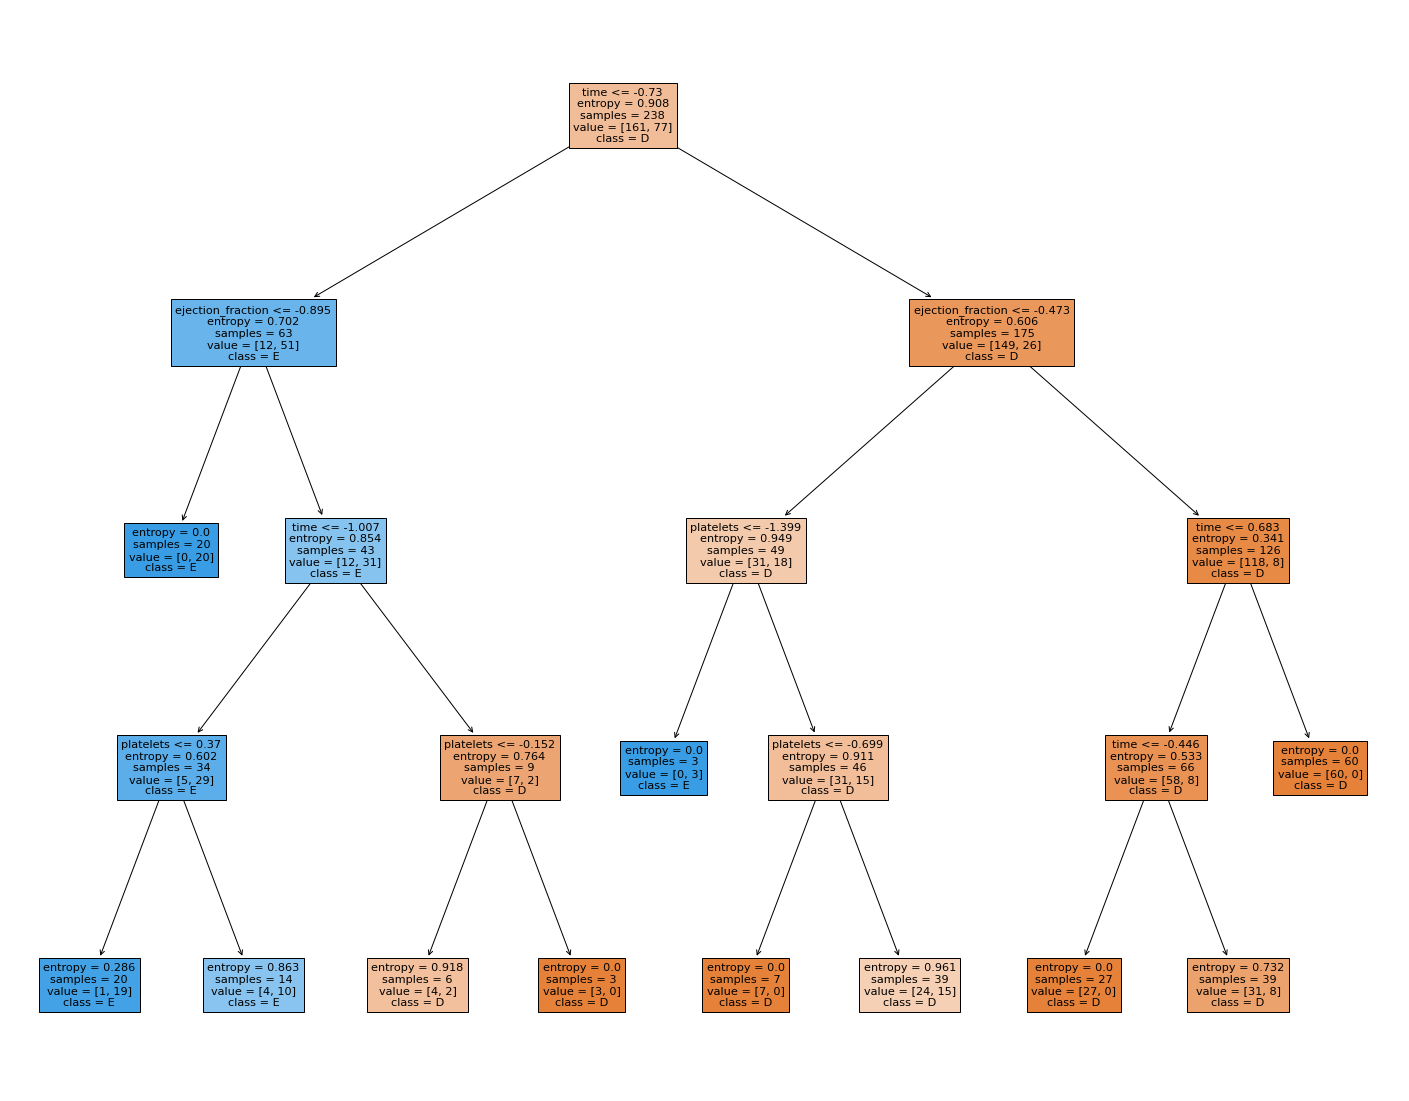

In [82]:
present_DTC(best_DTC_outliers_nosmote, important_features_of_DTC_outliers_nosmote, y_outliers)

In [83]:
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_nooutliers_smote)}')

Decision Tree Accuracy: 0.7758620689655172


In [84]:
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_nooutliers_nosmote)}')

Decision Tree Accuracy: 0.8103448275862069


In [85]:
print(f'Decision Tree Accuracy: {accuracy_score(y_test_outliers, y_pred_outliers_smote )}')

Decision Tree Accuracy: 0.8


In [86]:
print(f'Decision Tree Accuracy: {accuracy_score(y_test_outliers, y_pred_outliers_nosmote )}')

Decision Tree Accuracy: 0.85


Classification report for Decision Tree Model:

In [87]:
print(classification_report(y_test, y_pred_nooutliers_smote))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82        40
           1       0.60      0.83      0.70        18

    accuracy                           0.78        58
   macro avg       0.75      0.79      0.76        58
weighted avg       0.81      0.78      0.78        58



In [88]:
print(classification_report(y_test, y_pred_nooutliers_nosmote))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86        40
           1       0.71      0.67      0.69        18

    accuracy                           0.81        58
   macro avg       0.78      0.77      0.77        58
weighted avg       0.81      0.81      0.81        58



In [89]:
print(classification_report(y_test_outliers, y_pred_outliers_smote))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86        41
           1       0.71      0.63      0.67        19

    accuracy                           0.80        60
   macro avg       0.77      0.75      0.76        60
weighted avg       0.80      0.80      0.80        60



In [90]:
print(classification_report(y_test_outliers, y_pred_outliers_nosmote))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90        41
           1       0.92      0.58      0.71        19

    accuracy                           0.85        60
   macro avg       0.88      0.78      0.80        60
weighted avg       0.86      0.85      0.84        60



RANDOM FOREST

In [91]:
def print_accuracy_RF(X_train, y_train, X_test, y_test):
  clf = RandomForestClassifier(n_estimators=100)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print("Accuracy:", accuracy_score(y_pred, y_test))

In [92]:
print_accuracy_RF(X_train_nooutliers_smote, y_train_nooutliers_smote, X_test, y_test)

Accuracy: 0.7931034482758621


In [93]:
print_accuracy_RF(X_train_nooutliers_nosmote, y_train_nooutliers_nosmote, X_test, y_test)

Accuracy: 0.8448275862068966


In [94]:
print_accuracy_RF(X_train_outliers_smote, y_train_outliers_smote, X_test_outliers, y_test_outliers)

Accuracy: 0.8666666666666667


In [95]:
print_accuracy_RF(X_train_outliers_nosmote, y_train_outliers_nosmote, X_test_outliers, y_test_outliers)

Accuracy: 0.8666666666666667


**grid search**

In [96]:
def grid_search_random_forests():
  rfc = RandomForestClassifier()
  param_grid = { 
      'n_estimators': [100, 200],
      'max_features': ['auto', 'sqrt', 'log2'],
      'max_depth' : [2, 3, 4],
      'criterion' :['gini', 'entropy']
  }
  return GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)

In [97]:
def print_CV_RFC_accuracy(X_train, y_train, X_test, y_test, is_outliers):
  CV_rfc = grid_search_random_forests()
  CV_rfc.fit(X_train, y_train)
  y_pred = CV_rfc.predict(X_test)
  outliers_string = 'with' if is_outliers else 'without'
  print(f"Accuracy for Random Forest on CV data {outliers_string} OUTLIERS!!: ", accuracy_score(y_test, y_pred))

In [98]:
print_CV_RFC_accuracy(X_train_nooutliers_smote, y_train_nooutliers_smote, X_test, y_test, False)

Accuracy for Random Forest on CV data without OUTLIERS!!:  0.8275862068965517


In [99]:
print_CV_RFC_accuracy(X_train_nooutliers_nosmote, y_train_nooutliers_nosmote, X_test, y_test, False)

Accuracy for Random Forest on CV data without OUTLIERS!!:  0.8448275862068966


In [100]:
print_CV_RFC_accuracy(X_train_outliers_smote, y_train_outliers_smote, X_test_outliers, y_test_outliers, True)

Accuracy for Random Forest on CV data with OUTLIERS!!:  0.8833333333333333


In [101]:
print_CV_RFC_accuracy(X_train_outliers_nosmote, y_train_outliers_nosmote, X_test_outliers, y_test_outliers, True)

Accuracy for Random Forest on CV data with OUTLIERS!!:  0.8666666666666667


**Logistic regresion model**: let's find the best HyperParameters.

**Best attributes to use for logistic regression  are** 'serum_creatinine', 'ejection_fraction','time','creatinine_phosphokinase' based on the corralation matrix above, and based on the conclusions of feature importants thats written on decision tree section above.



In [111]:
def logreg_find_best_params(X_train, y_train, title):
  
  # pdb.set_trace()

  grid={"C":np.logspace(-3,3,7), "penalty":["l2"]}
  logreg = LogisticRegression()
  logreg.fit(X_train, y_train)
  
  coefs = np.abs(logreg.coef_[0])
  indices = np.argsort(coefs)[::-1]
  plt.figure()
  plt.title(f"Feature importances - Logistic Regression - {title}")
  plt.bar(range(12), coefs[indices[:12]], color="r", align="center")
  plt.xticks(range(12), df.columns[indices[:12]], rotation=45, ha='right')
  plt.subplots_adjust(bottom=0.3)

  important_features_LR = df.columns[indices[:3]]

  logreg_cv = GridSearchCV(logreg, grid, cv=10)
  logreg_cv.fit(X_train[important_features_LR], y_train)

  print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
  print("accuracy :", logreg_cv.best_score_)
  best_C = logreg_cv.best_params_['C']
  best_penalty = logreg_cv.best_params_['penalty']
  return best_C, best_penalty, important_features_LR



tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2'}
accuracy : 0.8411290322580645
tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2'}
accuracy : 0.8306159420289856
tuned hpyerparameters :(best parameters)  {'C': 100.0, 'penalty': 'l2'}
accuracy : 0.8295454545454545
tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2'}
accuracy : 0.8161231884057971


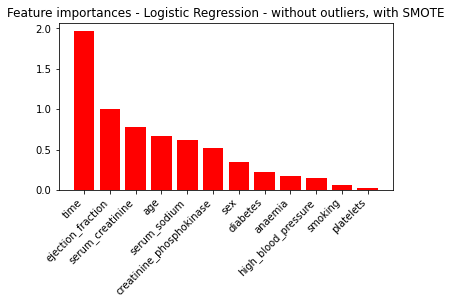

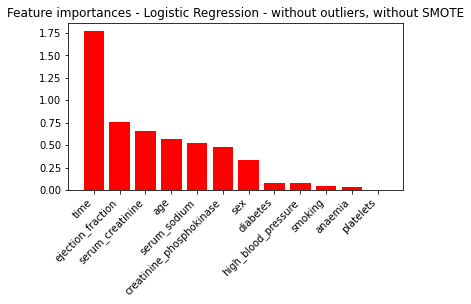

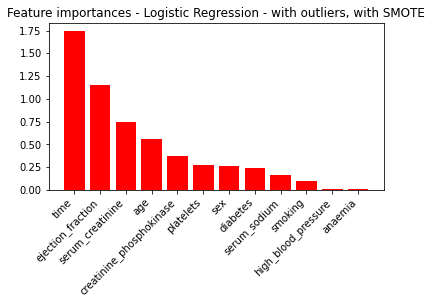

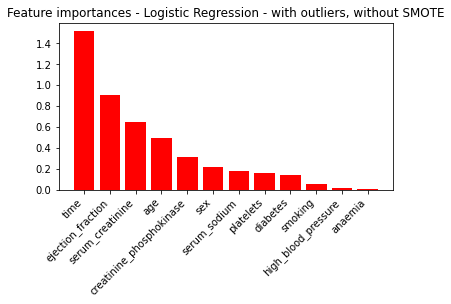

In [112]:
best_C_nooutliers_smote , best_penalty_nooutliers_smote, important_features_LR_nooutliers_smote = logreg_find_best_params(X_train_nooutliers_smote, y_train_nooutliers_smote, 'without outliers, with SMOTE')
best_C_nooutliers_nosmote, best_penalty_nooutliers_nosmote, important_features_LR_nooutliers_nosmote = logreg_find_best_params(X_train_nooutliers_nosmote, y_train_nooutliers_nosmote, 'without outliers, without SMOTE')
best_C_outliers_smote , best_penalty_outliers_smote, important_features_LR_outliers_smote = logreg_find_best_params(X_train_outliers_smote, y_train_outliers_smote, 'with outliers, with SMOTE')
best_C_outliers_nosmote , best_penalty_outliers_nosmote, important_features_LR_outliers_nosmote = logreg_find_best_params(X_train_outliers_nosmote, y_train_outliers_nosmote, 'with outliers, without SMOTE')

**tuned hpyerparameters** :(best parameters)  {'C': 100.0, 'penalty': 'l2'}

In [113]:
def generic_LogisticRegressionCV(X_train,y_train,X_test,y_test,important_features_LR,best_C,best_penalty):
  logistic = LogisticRegressionCV(Cs=best_C, fit_intercept=True, cv=10,penalty=best_penalty, verbose=1)
  logistic.fit(X_train[important_features_LR], y_train)
  y_pred = logistic.predict(X_test[important_features_LR])

  print(f'Logistic regression Accuracy: {accuracy_score(y_test, y_pred)}')
  print(logistic.coef_) # weights of each feature
  print(logistic.intercept_) # value of intercept
  return y_pred

In [114]:
y_pred_nooutliers_smote = generic_LogisticRegressionCV(X_train_nooutliers_smote,y_train_nooutliers_smote, X_test, y_test, important_features_LR_nooutliers_smote, [best_C_nooutliers_smote], best_penalty_nooutliers_smote )

Logistic regression Accuracy: 0.8275862068965517
[[-1.88729194 -0.78423772  0.97771781]]
[-0.80832232]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [115]:
y_pred_nooutliers_nosmote = generic_LogisticRegressionCV(X_train_nooutliers_nosmote, y_train_nooutliers_nosmote, X_test,y_test, important_features_LR_nooutliers_nosmote, [best_C_nooutliers_nosmote], best_penalty_nooutliers_nosmote)

Logistic regression Accuracy: 0.7931034482758621
[[-1.14243205 -0.44565499  0.58148851]]
[-1.06738989]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [116]:
y_pred_outliers_smote = generic_LogisticRegressionCV(X_train_outliers_smote,y_train_outliers_smote,X_test_outliers,y_test_outliers,important_features_LR_outliers_smote,[best_C_outliers_smote ], best_penalty_outliers_smote)

Logistic regression Accuracy: 0.8333333333333334
[[-1.77235242 -1.05261643  0.84203601]]
[-0.81922686]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [117]:
y_pred_outliers_nosmote = generic_LogisticRegressionCV(X_train_outliers_nosmote,y_train_outliers_nosmote,X_test_outliers,y_test_outliers,important_features_LR_outliers_nosmote , [best_C_outliers_nosmote] , best_penalty_outliers_nosmote)

Logistic regression Accuracy: 0.8666666666666667
[[-1.49628372 -0.80297916  0.71108617]]
[-1.26746167]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


**Important Note**: the weights we got from running logistic regression. These weights, which are the coefficients of the instance vector of each Instance x, multiplied by the vector, indicate a probability of y. Assuming a multiplication result greater than 0.5 this is a positive classification, meaning the patient will die, otherwise negative.

TP = True Positive

TN = True Negative

FP = False Positive

FN = False Negative


Precision: The ratio between correctly predicted positive observations and the total predicted positive observations. 

The question that this metric answers is of all the patients that were predicted to die, how many actually died? 
High precision relates to the low false positive rate. 

Precision = TP/TP+FP


Recall (Sensitivity): The ratio between correctly predicted positive observations and all of the observations in the actual class - yes.

The question recall answers is: Of all the patients that died, how many did we predict to die? 

Recall = TP/TP+FN


F1-Score: The weighted average of Precision and Recall.

It takes both false positives and false negatives into account, equally weighted.

Accuracy: The most intuitive performance measure which is simply a ratio between correctly predicted observations and all of the total observations. 
Higher accuracy doesn't necessarily mean a better model, because our data could be imbalanced (as it was in our case). 

For example, extreme imbalanced data (99% dead patients, 1% living patients) could be predicted with high accuracy (99% accuracy to be exact) using a "stupid" algorithm that just "predicts" *True* for every observation in the dataset. For this example of 99%, it's probably better to use Recall.

Accuracy = TP+TN / TP+FP+FN+TN



Classification report for Logistic regression:

In [ ]:
print(classification_report(y_test, y_pred_nooutliers_smote))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        40
           1       0.72      0.72      0.72        18

    accuracy                           0.83        58
   macro avg       0.80      0.80      0.80        58
weighted avg       0.83      0.83      0.83        58



In [ ]:
print(classification_report(y_test, y_pred_nooutliers_nosmote))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89        40
           1       0.80      0.67      0.73        18

    accuracy                           0.84        58
   macro avg       0.83      0.80      0.81        58
weighted avg       0.84      0.84      0.84        58



In [ ]:
print(classification_report(y_test_outliers, y_pred_outliers_smote))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86        41
           1       0.68      0.79      0.73        19

    accuracy                           0.82        60
   macro avg       0.79      0.81      0.80        60
weighted avg       0.83      0.82      0.82        60



In [ ]:
print(classification_report(y_test_outliers, y_pred_outliers_nosmote))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90        41
           1       0.82      0.74      0.78        19

    accuracy                           0.87        60
   macro avg       0.85      0.83      0.84        60
weighted avg       0.86      0.87      0.86        60



SVM

**grid search**

In [ ]:
def generic_grid_searchSVM(grid,cv,scoring,X_train,y_train,X_test):
  svm = SVC()
  model_svm = GridSearchCV(svm , tuned_parameters,cv=10,scoring=scoring) 
  model_svm.fit(X_train, y_train)  
  y_pred = model_svm.predict(X_test)
  return y_pred

In [ ]:
tuned_parameters = {
  'C': (np.arange(0.1,1,0.1)) , 'kernel': ['linear'],
  'C': (np.arange(0.1,1,0.1)) , 'gamma': [0.01,0.02,0.03,0.04,0.05], 'kernel': ['rbf'],
  'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05], 'C':(np.arange(0.1,1,0.1)) , 'kernel':['poly']
                    }
cv = 10
accuracy = 'accuracy'                    

In [ ]:
y_pred_nooutliers_smote = generic_grid_searchSVM(tuned_parameters,cv,accuracy,X_train_nooutliers_smote,y_train_nooutliers_smote,X_test)

In [ ]:
y_pred_nooutliers_nosmote = generic_grid_searchSVM(tuned_parameters,cv,accuracy,X_train_nooutliers_nosmote,y_train_nooutliers_nosmote,X_test)

In [ ]:
y_pred_outliers_smote = generic_grid_searchSVM(tuned_parameters,cv,accuracy,X_train_outliers_smote,y_train_outliers_smote,X_test_outliers)

In [ ]:
y_pred_outliers_nosmote = generic_grid_searchSVM(tuned_parameters,cv,accuracy,X_train_outliers_nosmote,y_train_outliers_nosmote,X_test_outliers)

In [ ]:
print(accuracy_score(y_pred_nooutliers_smote, y_test))

0.7931034482758621


In [ ]:
print(accuracy_score(y_pred_nooutliers_nosmote, y_test))

0.6896551724137931


In [ ]:
print(accuracy_score(y_pred_outliers_smote, y_test_outliers))

0.8666666666666667


In [ ]:
print(accuracy_score(y_pred_outliers_nosmote, y_test_outliers))

0.7166666666666667


# Cross validate models*

Cross-validation is a resampling procedure used to evaluate models on a limited data sample. 

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. 

As such, the procedure is often called k-fold cross-validation.

Stratified k-fold cross validation is an extension of regular k-fold cross validation, but specifically for classification problems, where rather than the splits being completely random, the ratio between the target classes is the same in each fold as it is in the full dataset.

We compared the 2 popular classifiers and evaluate the mean accuracy of each of them by a stratified k-fold cross validation procedure.

In [ ]:
def graph_cv_model_scores(X_train,y_train,X_test,scoring,random_state,important_features_LR,important_features_of_DTC,max_depth_of_DTC,best_criterion_DTC,best_C_LR,best_penalty_LR):
  # Cross validate model with Kfold stratified cross val
  kfold = StratifiedKFold(n_splits=10)

  # Modeling step Test differents algorithms 
  classifiers = []
  classifiers.append(DecisionTreeClassifier(criterion=best_criterion_DTC,
                                            max_depth=max_depth_of_DTC,
                                            random_state=randomState))
  classifiers.append(LogisticRegression(penalty=best_penalty_LR, 
                                        C=best_C_LR, 
                                        random_state=randomState))

  cv_results = []

  cv_results.append(cross_val_score(classifiers[0], 
                                    X_train[important_features_of_DTC], 
                                    y_train, 
                                    scoring=scoring, 
                                    cv=kfold, 
                                    n_jobs=4))

  cv_results.append(cross_val_score(classifiers[1], 
                                    X_train[important_features_LR], 
                                    y_train, 
                                    scoring=scoring, 
                                    cv=kfold, 
                                    n_jobs=4))

  cv_means = []
  cv_std = []
  for cv_result in cv_results:
      cv_means.append(cv_result.mean())
      cv_std.append(cv_result.std())
      print(cv_result.mean())

  cv_res = pd.DataFrame({"CrossValMeans":cv_means, 
                        "CrossValerrors": cv_std, 
                        "Algorithm":["DecisionTree", "LogisticRegression"]})

  g = sns.barplot("CrossValMeans", 
                  "Algorithm", 
                  data=cv_res, 
                  palette="Set3", 
                  orient = "h", 
                  **{'xerr':cv_std})

  g.set_xlabel("Mean Accuracy")
  g = g.set_title("Cross validation scores")  

0.854032258064516
0.8318548387096774


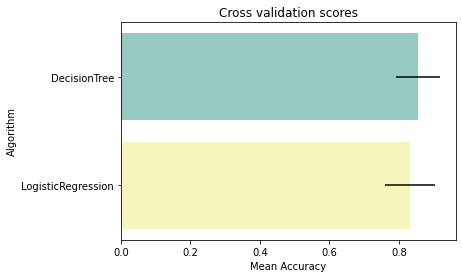

In [ ]:
graph_cv_model_scores(X_train_nooutliers_smote, y_train_nooutliers_smote, X_test, 'accuracy', randomState, important_features_LR, important_features_of_DTC_nooutliers_smote, max_depth_nooutliers_smote, best_criterion_nooutliers_smote, best_C_nooutliers_smote, best_penalty_nooutliers_smote)

0.8567028985507246
0.8396739130434783


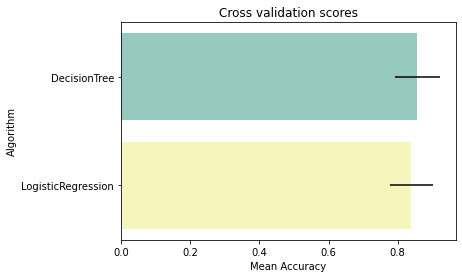

In [ ]:
graph_cv_model_scores(X_train_nooutliers_nosmote,y_train_nooutliers_nosmote,X_test,'accuracy',randomState,important_features_LR,important_features_of_DTC_nooutliers_nosmote,max_depth_nooutliers_nosmote,best_criterion_nooutliers_nosmote,best_C_nooutliers_nosmote,best_penalty_nooutliers_nosmote)

0.8388257575757576
0.8107954545454545


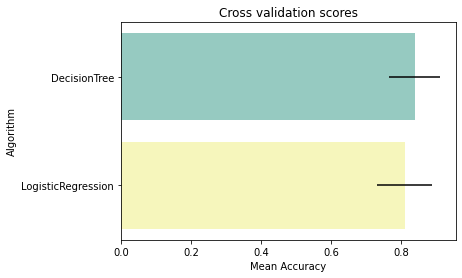

In [ ]:
graph_cv_model_scores(X_train_outliers_smote,y_train_outliers_smote,X_test_outliers,'accuracy',randomState,important_features_LR,important_features_of_DTC_outliers_smote,max_depth_outliers_smote,best_criterion_outliers_smote,best_C_outliers_smote,best_penalty_outliers_smote)

0.8452898550724637
0.8244565217391304


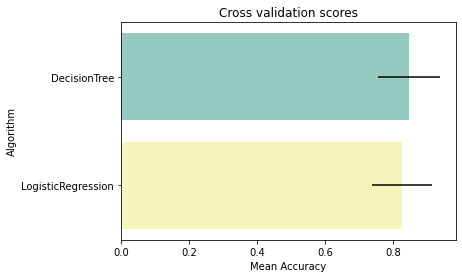

In [ ]:
graph_cv_model_scores(X_train_outliers_nosmote,y_train_outliers_nosmote,X_test_outliers,'accuracy',randomState,important_features_LR,important_features_of_DTC_outliers_nosmote,max_depth_outliers_nosmote,best_criterion_outliers_nosmote,best_C_outliers_nosmote,best_penalty_outliers_nosmote)

In [ ]:
# Learning curve
def Learning_curve_model(X, Y, model, cv, train_sizes):

    plt.figure()
    plt.title("Learning curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(model, X, Y, cv=cv, n_jobs=4, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes,
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, 
                    alpha=0.1,
                    color="r")
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, 
                     color="g")
    plt.plot(train_sizes, 
             train_scores_mean, 
             'o-', 
             color="r",
             label="Training score")
    plt.plot(train_sizes, 
             test_scores_mean, 
             'o-', 
             color="g",
             label="Cross-validation score")
                     
    plt.legend(loc="best")
    return plt

**learning curve for outliers & smote**

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

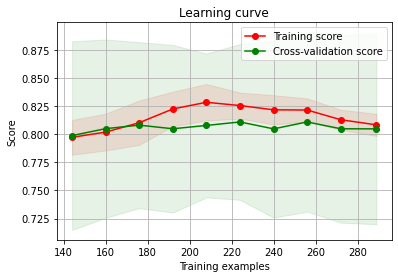

In [ ]:
logreg  = LogisticRegression()
#DTC = DecisionTreeClassifier()
cv = 10
train_size=np.linspace(.5, 1.0, 10)
Learning_curve_model(X_train_outliers_smote[important_features_LR], y_train_outliers_smote, logreg, cv, train_size)
# Learning_curve_model(X[important_features_DTC], y, DTC, cv,train_size)

**learning curve for no outliers & smote**

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

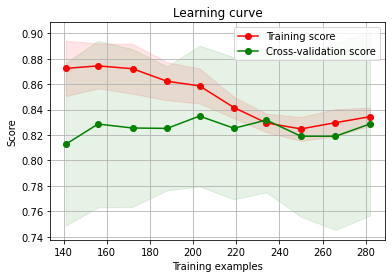

In [ ]:
logreg  = LogisticRegression()
#DTC = DecisionTreeClassifier()
cv = 10
train_size=np.linspace(.5, 1.0, 10)
Learning_curve_model(X_train_nooutliers_smote[important_features_LR], y_train_nooutliers_smote, logreg, cv, train_size)
# Learning_curve_model(X[important_features_DTC], y, DTC, cv,train_size)

**learing curve for outliers & no smote**

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

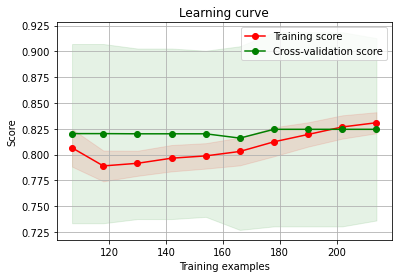

In [ ]:
logreg  = LogisticRegression()
#DTC = DecisionTreeClassifier()
cv = 10
train_size=np.linspace(.5, 1.0, 10)
Learning_curve_model(X_train_outliers_nosmote[important_features_LR], y_train_outliers_nosmote, logreg, cv, train_size)
# Learning_curve_model(X[important_features_DTC], y, DTC, cv,train_size)

**learning curve for nooutliers & no smote**

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

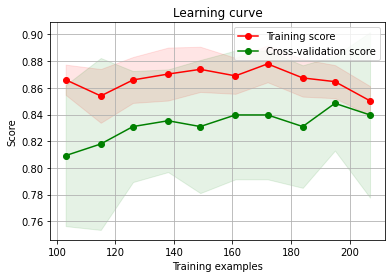

In [ ]:
logreg  = LogisticRegression()
#DTC = DecisionTreeClassifier()
cv = 10
train_size=np.linspace(.5, 1.0, 10)
Learning_curve_model(X_train_nooutliers_nosmote[important_features_LR], y_train_nooutliers_nosmote, logreg, cv, train_size)
# Learning_curve_model(X[important_features_DTC], y, DTC, cv,train_size)

A conclusion from the red graph of training on a single training set shows that the larger the set, the smaller the over-fit, and therefore the accuracy decreases, meaning that the score accuracy decreases gradually.
The green graph shows that the 10cross validation technique is really  effective, because it prevents overfitting already starting from a small set size so the green graph does not have a negative slope. 
This can be explained by the fact that the error estimation of this technique is with smaller bias and also with smaller variance, in simple words, the larger the "survey" (10 folds) the better the forecast.

**An important conclusion** from the chart: the more you increase the amount of data, the more accurate results you get for the regression model, but increasing the amount of data from a certain point (250) does not contribute to that anymore - you can see this by the converging of the two graphs to a horizontal asymptote.
and thats also indicate a decreasing in overall overfitting  

#Artificial Neural Network 
how we build the model:

*   Initialising the ANN
*   Defining by adding layers
*   Compiling the ANN
*   Train the ANN





In [ ]:
def generic_ANN( X,y,min_delta=0.05,patience=100):
  early_stopping = callbacks.EarlyStopping(
      #min_delta=0.05, # minimium amount of change to count as an improvement
      min_delta=min_delta,
      #patience=100, # how many epochs to wait before stopping
      patience=patience,
      restore_best_weights=True)

  # Initialising the NN
  model = Sequential()

  # layers
  model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))
  model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
  model.add(Dropout(0.25))
  model.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
  # Compiling the ANN
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

  # Train the ANN

  history = model.fit(X, y, batch_size = 32, verbose = 0, epochs = 500,callbacks=[early_stopping], validation_split=0.2) 
  return history , model 

Full run of AAN 

In [ ]:
history_nooutliers_smote ,model_nooutliers_smote= generic_ANN(X_train_nooutliers_smote,y_train_nooutliers_smote)

In [ ]:
history_nooutliers_nosmote , model_nooutliers_nosmote= generic_ANN(X_train_nooutliers_nosmote,y_train_nooutliers_nosmote)

In [ ]:
history_outliers_smote , model_outliers_smote= generic_ANN(X_train_outliers_smote,y_train_outliers_smote)

In [ ]:
history_outliers_nosmote , model_outliers_nosmote= generic_ANN(X_train_outliers_nosmote,y_train_outliers_nosmote)

In [ ]:
def print_val_accuracy(history,type_of_data):
  val_accuracy = np.mean(history.history['val_accuracy'])
  print("\n%s: %.2f%%" % ('val_accuracy on ' + type_of_data+'', val_accuracy*100))

In [ ]:
print_val_accuracy(history_nooutliers_smote,'nooutliersXsmote')


val_accuracy on nooutliersXsmote: 90.50%


In [ ]:
print_val_accuracy(history_nooutliers_nosmote,'nooutliersXnosmote')


val_accuracy on nooutliersXnosmote: 74.91%


In [ ]:
print_val_accuracy(history_outliers_smote,'outliersXsmote')


val_accuracy on outliersXsmote: 74.28%


In [ ]:
print_val_accuracy(history_outliers_nosmote,'outliersXnosmote')


val_accuracy on outliersXnosmote: 85.65%


Plotting training and validation loss over epochs

In [ ]:
def print_loss(history,type_of_data):
  history = pd.DataFrame(history.history)

  plt.plot(history.loc[:, ['loss']], "#6daa9f", label='Training loss')
  plt.plot(history.loc[:, ['val_loss']],"#774571", label='Validation loss')
  plt.title('Training and Validation loss on'+' '+type_of_data+' dataset')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc="best")

  plt.show()

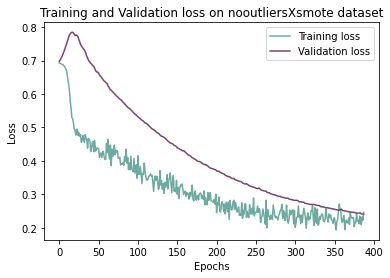

In [ ]:
print_loss(history_nooutliers_smote,'nooutliersXsmote')

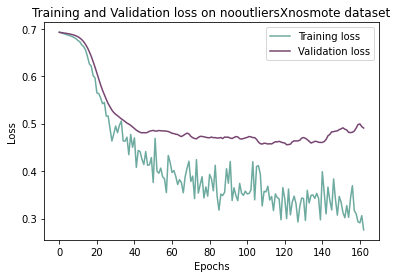

In [ ]:
print_loss(history_nooutliers_nosmote,'nooutliersXnosmote')

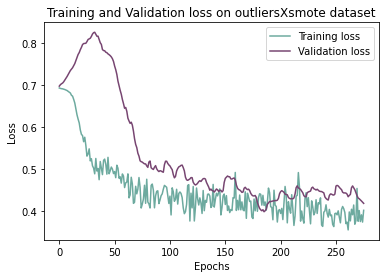

In [ ]:
print_loss(history_outliers_smote,'outliersXsmote')

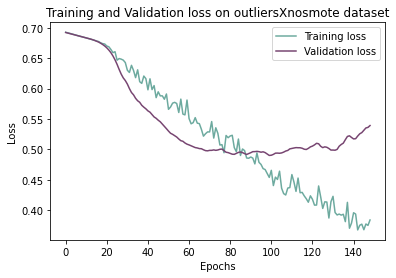

In [ ]:
print_loss(history_outliers_nosmote,'outliersXnosmote')

Plotting training and validation accuracy over epochs

In [ ]:
def plot_accuracy(history,type_of_data):
  history = pd.DataFrame(history.history)

  plt.plot(history.loc[:, ['accuracy']], "#6daa9f", label='Training accuracy')
  plt.plot(history.loc[:, ['val_accuracy']], "#774571", label='Validation accuracy')

  plt.title('Training and Validation accuracy on '+ type_of_data)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

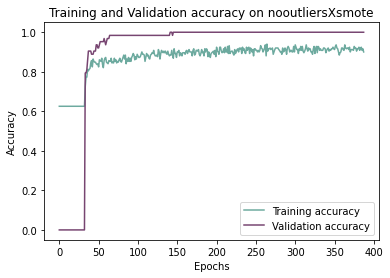

In [ ]:
plot_accuracy(history_nooutliers_smote,'nooutliersXsmote')

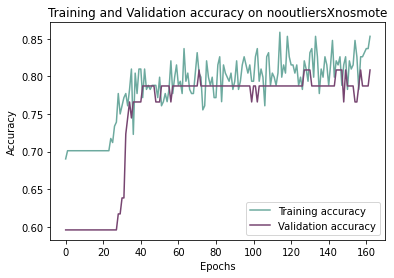

In [ ]:
plot_accuracy(history_nooutliers_nosmote,'nooutliersXnosmote')

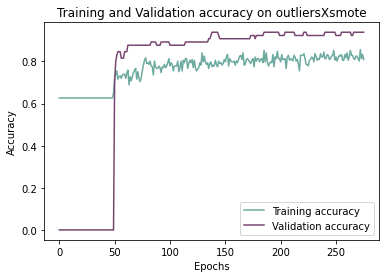

In [ ]:
plot_accuracy(history_outliers_smote,'outliersXsmote')

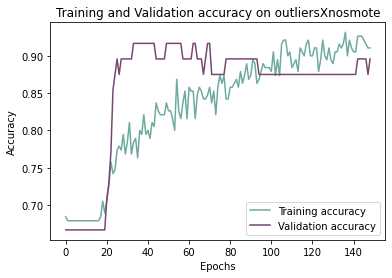

In [ ]:
plot_accuracy(history_outliers_nosmote,'outliersXnosmote')

Testing on the test set,

Evaluating the confusion matrix

Evaluating the classification report


In [ ]:
def print_confusion_matrix_and_accuracy_score(model,X_test,y_test,type_of_data):
  y_pred = model.predict(X_test)
  y_pred = (y_pred > 0.5)
  np.set_printoptions()
  print('accuracy score on '+type_of_data+ ' is ' + str(accuracy_score(y_test,y_pred)))
  # confusion matrix
  cmap1 = sns.diverging_palette(275,150,  s=40, l=65, n=6)
  plt.subplots(figsize=(12,8))
  cf_matrix = confusion_matrix(y_test, y_pred)
  sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

accuracy score on nooutliersXsmote is 0.8103448275862069


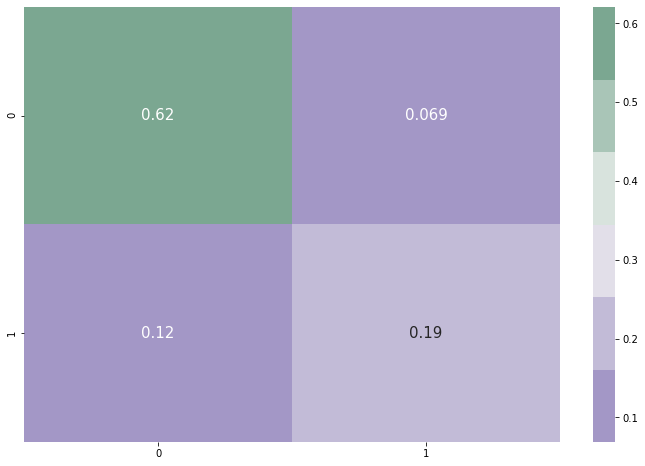

In [ ]:
print_confusion_matrix_and_accuracy_score(model_nooutliers_smote,X_test,y_test,'nooutliersXsmote')

accuracy score on nooutliersXnosmote is 0.8103448275862069


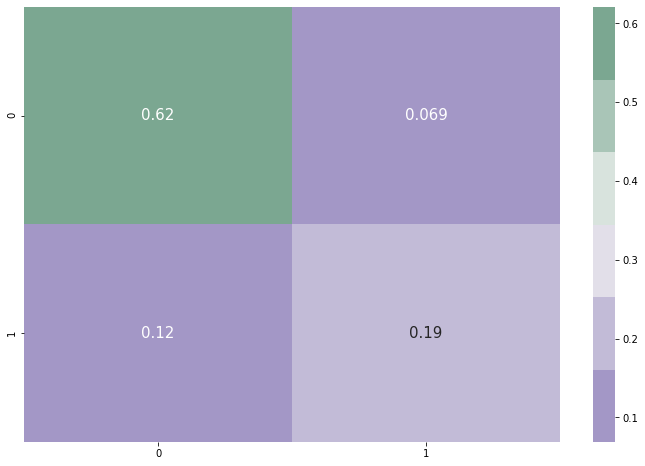

In [ ]:
print_confusion_matrix_and_accuracy_score(model_nooutliers_nosmote,X_test,y_test,'nooutliersXnosmote')

accuracy score on outliersXsmote is 0.8333333333333334


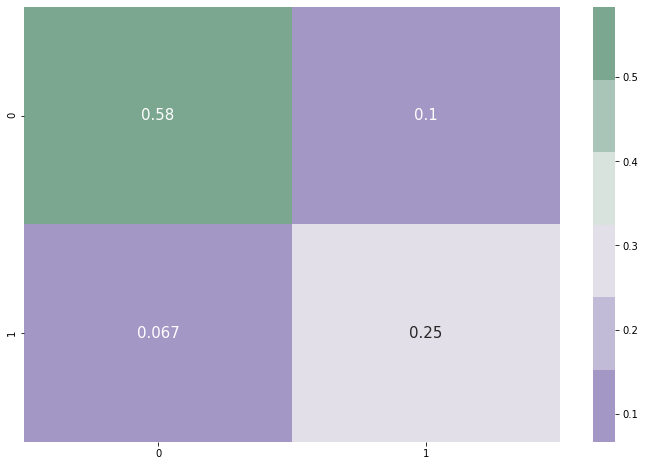

In [ ]:
print_confusion_matrix_and_accuracy_score(model_outliers_smote,X_test_outliers,y_test_outliers,'outliersXsmote')

accuracy score on outliersXnosmote is 0.8166666666666667


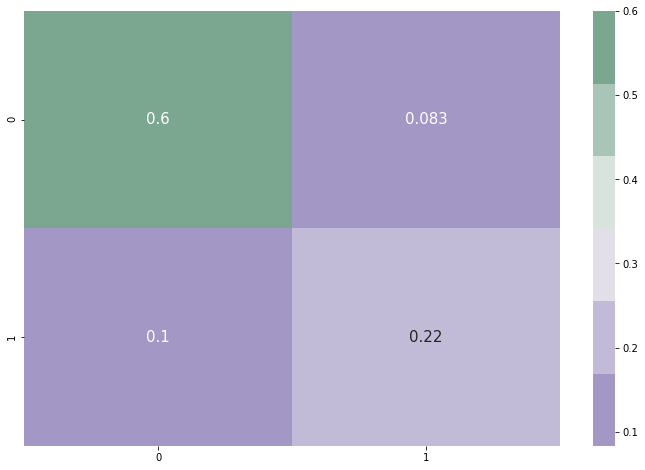

In [ ]:
print_confusion_matrix_and_accuracy_score(model_outliers_nosmote,X_test_outliers,y_test_outliers,'outliersXnosmote')

#AutoML

TPOT is an AutoML library in python that optimizes ML pipelines using genetic programming.

[Genetic Programming](https://en.wikipedia.org/wiki/Genetic_programming) is an automatic programming technique that favors the evolution of computer programs that solve (or approximately solve) problems.

TPOT would also search for the best (accuracy wise) hyperparameters for us.



In [ ]:

def run_tpot(X_train, y_train):
  tpot = TPOTClassifier(generations=None,
                      random_state=randomState, 
                      max_time_mins=60,
                      n_jobs=-1)
  tpot.fit(X_train, y_train)
  print(tpot.score(X_test, y_test))
  return tpot


The above method would run for 1 hour to find the best (accuracy wise) pipeline.

We ran this method for each of the 4 cases (with/out outliers X with/out SMOTE) to see which data produces the best accuracy.

The result is in the following cells.




In [ ]:
# tpot_nooutliers_smote = run_tpot(X_train_nooutliers_smote, y_train_nooutliers_smote)

The accuracy found after running for one hour for the above case of WITHOUT outliers and WITH SMOTE is: 0.89

In [ ]:
# tpot_nooutliers_nosmote = run_tpot(X_train_nooutliers_nosmote, y_train_nooutliers_nosmote)

The accuracy found after running for one hour for the above case of WITHOUT outliers and WITHOUT SMOTE is: 0.93

In [ ]:
# tpot_outliers_smote = run_tpot(X_train_outliers_smote, y_train_outliers_smote)

The accuracy found after running for one hour for the above case of WITH outliers and WITH SMOTE is: 0.97

In [ ]:
# tpot_outliers_nosmote = run_tpot(X_train_outliers_nosmote, y_train_outliers_nosmote)

The accuracy found after running for one hour for the above case of WITH outliers and WITHOUT SMOTE is: 0.89

We saw that the best accuracy is ~0.97 so we took tpot_outliers_smote.

From that, we extracted tpot_outliers_smote.fitted_pipeline_ to get the best pipeline/model with its best hyperparameters.

We present it in the following cell:

In [ ]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neural_network import MLPClassifier
from tpot.builtins import StackingEstimator

pipeline = Pipeline(steps=[('maxabsscaler', MaxAbsScaler()),
                          ('stackingestimator', StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=0.01,
                                                                  max_depth=5,
                                                                  max_features=0.5,
                                                                  min_samples_leaf=8,
                                                                  min_samples_split=5,
                                                                  random_state=randomState,
                                                                  subsample=0.45))),
                          ('mlpclassifier', MLPClassifier(alpha=0.001, learning_rate_init=0.01, random_state=randomState))])
pipeline.fit(X_train_outliers_smote, y_train_outliers_smote)
print("%.2f" % pipeline.score(X_test, y_test))

0.97


MaxAbsScaler: 

This estimator scales and translates each feature individually such that the maximal absolute value of each feature in the training set will be 1.0. It does not shift/center the data, and thus does not destroy any sparsity.


MLPClassifier:

Multi-layer Perceptron classifier.

This model optimizes the log-loss function using LBFGS (an optimizer in the family of quasi-Newton methods) or stochastic gradient descent.

#Conclusions:


* We tried to give the decision tree the normalized data set (as I did logistical regression),
And it did not help increase Accuracy.
It was easy to estimate this in advance, since the value ranges within the operation of the algorithm of decision tree construction do not matter List item

* In logistical regression, normalization did not improve accuracy, but did provide insight into
Which features are more influential, the idea was that the greater the weights of the features the greater the importance of the feature. If the data set was not normalized it would not be possible to understand from the value of the weights, because they would probably be without any logic

* The normalization of the independent features having a big skewed in absolute value, improves the predictions of the models 

* It was possible to think that the skewed of the label (the dependent variable) would adversely affect the models, but it turned out not to because there was not enough extreme skew(only a prevalence of 65% for one label and 35% for a second label.)

* The more you increase the amount of data, the more accurate results you get for the regression model, but increasing the amount of data from a certain point (250) does not contribute to that anymore - you can see this by the converging of the two graphs to a horizontal asymptote of the last chart, thats also indicate a decreasing in overall overfitting 

* Choosing the right features caused better prediction of the test set.
For example in the logistic regression, the best features which produced the best score were: serum_creatinine, ejection_fraction , time, creatinine_phosphokin As we can see also from the HeatMap.
In the decision tree, the best features were: creatinine_phosphokinase ejection_fraction, time.

* Adding the synthetic data (SMOTE) to the training data improved the prediction of the non-synthetic test data in the decision tree.

* The performance of both models (Logistic Regression & Decision Tree) were similar on the training set, but on the test set - the decision tree was better than the logistic regression in ~0.5.

In [ ]:
end = time()
print(f'Run took {end-start} seconds')

Run took 1102.6935620307922 seconds
